# Модель для предсказания успешности стартапов

**Описание исследования**

В данном исследовании рассматривается задача прогнозирования закрытия стартапов на основе имеющихся данных об их операционной деятельности (функционаривали стартапы в период с 1980 по 2018 годы).

**Цель исследования** - разработать модель машинного обучения способную предсказывать, закроется ли стартап в будущем, на основе предоставленных признаков.

**Задачи исследования:**

1. Построить модель, которая сможет предсказать успешность стартапов (закроются стартапы или нет).
2. Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям или обладателям стартапов (какие факторы влияют на успешность стартапа).

**Описание исходных данных:**

- *Тренировочная выборка:* `kaggle_startups_train.csv`
- *Тестовая выборка (без целевого признака 'status'):* `kaggle_startups_test.csv`
- `name` — идентификатор (название) стартапа;
- `category_list` — список категорий, к которым относится стартап;
- `funding_total_usd` — общая сумма финансирования в USD;
- `status` — статус стартапа (`operating` или `closed`), целевой признак;
- `country_code` — код страны;
- `state_code` — код штата;
- `region` — регион;
- `city` — город;
- `funding_rounds` — количество раундов финансирования;
- `founded_at` - дата основания;
- `first_funding_at` - дата первого раунда финансирования;
- `last_funding_at` - дата последнего раунда финансирования;
- `closed_at` - дата закрытия стартапа (если применимо);
- `lifetime` - время существования стартапа в днях.

**План исследования**

***Шаг 1. Загрузить данные и изучить общую информацию о них:***

- [1.1 Загрузка данных](#1.1-Загрузка-данных)
- [1.2 Изучение данных](#1.2-Изучение-данных)
    - [`train_data`](#train_data)
    - [`test_data`](#test_data)

***Шаг 2. Предобработать (+подготовить) данные:***

- [2.1 Предобработка категориальных признаков](#2.1-Предобработка-категориальных-признаков)
    - [2.1.1 Для `train_data`](#2.1.1-Для-train_data)
    - [2.1.2 Для `test_data`](#2.1.2-Для-test_data)
- [2.2 Добавление новых признаков](#2.2-Добавление-новых-признаков)
    - [2.2.1 Для `train_data`](#2.2.1-Для-train_data)
    - [2.2.2 Для `test_data`](#2.2.2-Для-test_data)
- [2.3 Подготовка данных](#2.3-Подготовка-данных)

***Шаг 3. Провести исследовательский анализ данных:***

- [3.1 Анализ целевого и количественных признаков](#3.1-Анализ-целевого-и-количественных-признаков)
- [3.2 Анализ выбросов и сезонности](#3.2-Анализ-выбросов-и-сезонности)
- [3.3 Корреляционный анализ](#3.3-Корреляционный-анализ)

***Шаг 4. Создать и применить пайплайны для моделей + обучение моделей:***

- [4.1 Подготовка данных с помощью пайплайнов](#4.1-Подготовка-данных-с-помощью-пайплайнов)
- [4.2 Обучение моделей](#4.2-Обучение-моделей)
- [4.3 Выбор лучшей модели](#4.3-Выбор-лучшей-модели)

***Шаг 5. Провести анализ важности признаков:***

- [5.1 Графики важности с помощью метода SHAP](#5.1-Графики-важности-с-помощью-метода-SHAP)
- [5.2 Выводы о значимости признаков](#5.2-Выводы-о-значимости-признаков)

***Шаг 6. Сформировать итоговые выводы о работе:***

- [6.1 Общий вывод по проекту](#6.1-Общий-вывод-по-проекту)

## 1. Загрузка и изучение данных

### 1.1 Загрузка данных

In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap -q
!pip install catboost -q
!pip install rapidfuzz -q
!pip install imbalanced-learn -q
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
from scipy import stats as st
from rapidfuzz import fuzz, process

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
train_data = pd.read_csv('kaggle_startups_train.csv')
test_data = pd.read_csv('kaggle_startups_test.csv')

In [3]:
# Объявляю константы
RANDOM_STATE = 42

### 1.2 Изучение данных

In [4]:
def df_info(data):
    display(data.head())
    print('**********')
    display(data.tail())
    print('**********')
    display(data.info())
    print('**********')
    display(data.describe().T)
    print('**********')
    print('Количество явных дубликатов:', data.duplicated().sum())
    print('Количевтво пропусков:\n', data.isna().sum())
    print('******************************')

#### train_data

In [5]:
df_info(train_data)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


**********


,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN
52515,Apparcando,Online Rental|Parking|Price Comparison,270820.0,operating,ESP,60,Valencia,Valencia,1,2012-08-11,2014-06-13,2014-06-13,NaN


**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


None

**********


,count,mean,std,min,25%,50%,75%,max
funding_total_usd,42447.0,1.824748e+07,1.871173e+08,1.0,336027.5,2000000.0,10000000.0,3.007950e+10
funding_rounds,52516.0,1.740670e+00,1.374522e+00,1.0,1.0,1.0,2.0,1.900000e+01


**********
Количество явных дубликатов: 0
Количевтво пропусков:
 name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64
******************************


`train_data`
- Всего в датафрейме 52516 строк 13 солбцов, из них два числовых стобца - `funding_total_usd` и `funding_rounds`
- Присутствуют пропуски в следующих признаках - `name` (1), `category_list` (2465), `funding_total_usd` (10069), `country_code` (5502), `state_code` (6763), `region` (6359), `city` (6359), `closed_at` (47599)
- Явные дубликаты отсутствуют
- Предварительно - аномальных значений не обнаружено

Наибольшее количество пропусков наблюдается в столбце `closed_at`, что указывает на то, что стартап продолжает свою деятельность и не был закрыт. Чтобы убедиться в этом, я сравню наличие пропусков в `closed_at` со значениями в `status`. 

In [6]:
# подсчет количества несоответствий в статусах
mismatched_operating = (train_data['closed_at'].isna() & (train_data['status'] != 'operating')).sum()
mismatched_closed = (train_data['closed_at'].notna() & (train_data['status'] != 'closed')).sum()

# вывод результатов
print(f"Число несоответствий для 'operating': {mismatched_operating}")
print(f"Число несоответствий для 'closed': {mismatched_closed}")

Число несоответствий для 'operating': 0
Число несоответствий для 'closed': 0


Проверка показала, что несоответствий нет, поэтому заполнять пропуски я не буду — статус компании уже зафиксирован в `status`.

Столбец `name` служит уникальным идентификатором компании. В нем обнаружен один пропуск, поэтому удалю соответствующую строку.

In [7]:
# удаляю строку с пропущенным названием
train_data = train_data.dropna(subset=['name'])

**Обработка признаков:**

- Количественные признаки (`funding_total_usd`, `funding_rounds`): обработаю в пайплайне, протестировав несколько стратегий — заполнение средним, модой, медианой или специальным значением -1.
- Категориальные признаки (`category_list`, `country_code`, `state_code`, `region`, `city`): попробую заполнить пропуски.
- Столбцы с датами (`founded_at`, `first_funding_at`, `last_funding_at`, `closed_at`): приведу к типу datetime64, а при необходимости извлеку дополнительные признаки.

#### test_data

In [8]:
df_info(test_data)

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


**********


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386
13124,RingCentral,Communications Hardware|Messaging|Mobile|Offic...,50250000.0,USA,CA,SF Bay Area,San Mateo,6,2007-01-16,2012-11-21,5479


**********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


None

**********


,count,mean,std,min,25%,50%,75%,max
funding_total_usd,10547.0,1.654910e+07,9.217283e+07,1.0,320000.0,2000000.0,10000000.0,4.715000e+09
funding_rounds,13125.0,1.714438e+00,1.318800e+00,1.0,1.0,1.0,2.0,1.500000e+01
lifetime,13125.0,3.097610e+03,2.128357e+03,52.0,1726.0,2526.0,3866.0,1.716700e+04


**********
Количество явных дубликатов: 0
Количевтво пропусков:
 name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64
******************************


`test_data`
- Всего в датафрейме 13125 строк, 11 столбцов
- Присутствуют пропуски в следующих признаках - `category_list` (591), `funding_total_usd` (2758), `country_code` (1382), `state_code` (1695), `region` (1589), `city` (1587)
- Явные дубликаты отсутствуют
- Предварительно - аномальных значений не обнаружено

**Промежуточные выводы изучения данных:**

В 2-х таблицах предоставлены данные о стартапах, их специфике и финансировании. 

Данные соответствуют описанию. Замечания до детального изучения для каждого из датасетов прописаны выше. Можно также добавить, что в данных отсутствуют явные дубликаты во всех датафреймах, но в предобработке данных (следующий шаг) обязательно необходимо будет проверить присутствие неявных дубликатов.

*Общие столбцы для двух датафреймов:*

`name`, `category_list`, `funding_total_usd`, `country_code`, `state_code`, `region`, `city`, `funding_rounds`, `first_funding_at` и `last_funding_at`

*Различия:*

- В тестовом наборе отсутствует целевой признак `status`.
- В тренировочной выборке присутствуют столбцы `founded_at` и `closed_at`, тогда как в тестовой есть `lifetime`, указывающий количество дней существования стартапа.

Добавлю аналогичный признак в тренировочную выборку, вычислив разницу между `founded_at` и `closed_at`. Для компаний, продолжающих работу, вместо даты закрытия возьму дату сбора данных — 1 января 2018 года. Перед этим приведу данные о датах к типу datetime64.

Однако признак `lifetime` может привести к утечке данных: модель может учитывать тот факт, что стартапы с большим временем существования на момент сбора данных все еще работают. Это может исказить прогнозы, так как длительный срок работы не всегда является показателем успеха. Протестирую этот признак, но буду обращать на него более пристальное внимание.

## 2. Предобработка данных

### 2.1 Предобработка категориальных признаков

#### 2.1.1 Для `train_data`

Чтобы избавиться от возможных неявных дубликатов, я удалю невидимые символы, приведу все значения к нижнему регистру и оставлю только буквы, исключив остальные символы:

In [9]:
# список текстовых столбцов
str_columns = ['category_list', 'region', 'city']

In [10]:
# привожу текст к нижнему регистру и удаляю лишние пробелы
train_data[str_columns] = train_data[str_columns].apply(lambda x: x.str.lower().str.strip())

In [11]:
for col in str_columns:
    print(f"Количество уникальных значений в '{col}' до обработки:", train_data[col].nunique())

Количество уникальных значений в 'category_list' до обработки: 22105
Количество уникальных значений в 'region' до обработки: 1036
Количество уникальных значений в 'city' до обработки: 4477


In [12]:
# функция ищет похожие значения в указанных столбцах, используя RapidFuzz
def find_similar_values(column, min_similarity=90):
    unique_values = train_data[column].dropna().unique()
    similar_values = []

    # Преобразуем в список для быстрого доступа
    unique_values = list(unique_values)

    for i, value in enumerate(unique_values):
        for other_value in unique_values[i+1:]:
            similarity = fuzz.token_sort_ratio(value, other_value)  # Учитывает порядок слов
            
            if similarity >= min_similarity:  # Если схожесть выше порога, добавляем
                similar_values.append((value, other_value, similarity))
    
    return similar_values

In [13]:
# поиск похожих значений и замена на унифицированные версии
for col in str_columns:
    similar_values = find_similar_values(col)
    replacement_dict = {variant: standard for standard, variant, _ in similar_values}
    train_data[col] = train_data[col].replace(replacement_dict)

In [14]:
for col in str_columns:
    print(f"Количество уникальных значений в '{col}' после обработки:", train_data[col].nunique())

Количество уникальных значений в 'category_list' после обработки: 20959
Количество уникальных значений в 'region' после обработки: 976
Количество уникальных значений в 'city' после обработки: 4378


In [15]:
# вывод случайных 10 строк для проверки
train_data[str_columns].sample(10)

,category_list,region,city
17786,semiconductors,sf bay area,san francisco
37085,e-commerce|internet,salt lake city,provo
12115,advertising|email,london,london
34698,design,atlanta,atlanta
20212,advertising|internet marketing|local|loyalty p...,denver,centennial
13362,finance|fintech|personal finance,madrid,madrid
33977,curated web,sf bay area,san mateo
50108,design|semiconductors|technology,sf bay area,sunnyvale
13588,finance,singapore,singapore
23482,enterprise software|internet|saas|software,sf bay area,san francisco


В столбце `category_list` почти 21 тысяча уникальных значений, закодирую их частотой встречаемости

In [16]:
# подсчет частоты встречаемости категорий и добавление нового признака
train_data['category_freq'] = train_data['category_list'].map(train_data['category_list'].value_counts())

# просмотр первых строк с новым признаком
train_data[['category_list', 'category_freq']].head()

,category_list,category_freq
0,online reservations|restaurants,1.0
1,manufacturing|medical|medical devices,10.0
2,biotechnology,2905.0
3,health care,744.0
4,manufacturing,604.0


#### 2.1.2 Для `test_data`

Чтобы избавиться от возможных неявных дубликатов, я удалю невидимые символы, приведу все значения к нижнему регистру и оставлю только буквы, исключив остальные символы:

In [17]:
# привожу текст к нижнему регистру и удаляю лишние пробелы
test_data[str_columns] = test_data[str_columns].apply(lambda x: x.str.lower().str.strip())

In [18]:
# вывод количества уникальных значений в каждом столбце
for col in str_columns:
    print(f"Уникальных значений в '{col}':", test_data[col].nunique())

Уникальных значений в 'category_list': 6206
Уникальных значений в 'region': 688
Уникальных значений в 'city': 2117


In [19]:
# поиск и замена схожих значений
for col in str_columns:
    similar_values = find_similar_values(col)
    replacement_dict = {variant: standard for standard, variant, _ in similar_values}
    test_data[col] = test_data[col].replace(replacement_dict)

In [20]:
# подсчет частоты встречаемости категорий и добавление нового признака
test_data['category_freq'] = test_data['category_list'].map(test_data['category_list'].value_counts())

# вывод информации о новых данных
test_data[['category_list', 'category_freq']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   category_list  12534 non-null  object 
 1   category_freq  12534 non-null  float64
dtypes: float64(1), object(1)
memory usage: 205.2+ KB


### 2.2 Добавление новых признаков

#### 2.2.1 Для `train_data`

Добавлю новый признак `lifetime` в тренировочную выборку:

In [21]:
# преобразую столбцы с датами в формат datetime
date_columns = ['founded_at', 'closed_at', 'first_funding_at', 'last_funding_at']
train_data[date_columns] = train_data[date_columns].apply(pd.to_datetime)

# рассчитываю срок существования стартапа (в днях)
train_data['lifetime'] = (train_data['closed_at'] - train_data['founded_at']).dt.days

# если компания не закрылась, заменяю NaN разницей с датой выгрузки (01.01.2018)
unloading_date = pd.to_datetime('2018-01-01')
train_data['lifetime'] = train_data['lifetime'].fillna((unloading_date - train_data['founded_at']).dt.days)

# вывожу первые строки для проверки
print(train_data[['founded_at', 'closed_at', 'lifetime']].head())

  founded_at closed_at  lifetime
0 2009-10-17       NaT    2998.0
1 2005-01-01       NaT    4748.0
2 2006-01-01       NaT    4383.0
3 2004-01-01       NaT    5114.0
4 2010-05-12       NaT    2791.0


Признаки `country_code`, `state_code`, `city`, `region` содержат информацию о локации стартапа. Для дальнейшей работы использую объединенный признак `country_code` и `state_code`, закодированный частотностью.

In [22]:
# создаю новый столбец с объединением страны и штата
train_data['country_state'] = train_data['country_code'] + '_' + train_data['state_code'].fillna('')

# подсчитываю количество вхождений каждой уникальной комбинации "страна_штат"
country_state_counts = train_data['country_state'].value_counts()

# добавляю частоту встречаемости в новый столбец
train_data['country_state_freq'] = train_data['country_state'].map(country_state_counts)

# вывожу первые строки для проверки
print(train_data[['country_state', 'country_state_freq']].head())

  country_state  country_state_freq
0        CHE_25               100.0
1        USA_CA             10219.0
2        USA_CA             10219.0
3           NaN                 NaN
4        USA_VA               581.0


Обнаружены пропущенные значения в новом столбце, что связано с наличием пропусков в исходных данных. Их обработаю в пайплайне, заменив на константу -1.

*Добавлю в данные следующие признаки:*

- Год первого финансирования
- Месяц первого финансирования 
- Год последнего финансирования
- Месяц последнего финансирования (учитываю для возможного анализа сезонности)
- Продолжительность финансирования – разница в днях между первым и последним финансированием
- Средняя сумма финансирования – общая сумма финансирования, деленная на количество раундов

Эти же признаки добавлю и в тестовую выборку позже.

In [23]:
# извлекаю год и месяц получения первого и последнего финансирования
train_data['first_funding_year'] = train_data['first_funding_at'].dt.year
train_data['first_funding_month'] = train_data['first_funding_at'].dt.month
train_data['last_funding_year'] = train_data['last_funding_at'].dt.year
train_data['last_funding_month'] = train_data['last_funding_at'].dt.month

In [24]:
# рассчитываю продолжительность финансирования (разницу в днях между первым и последним финансированием)
train_data['funding_duration'] = (train_data['last_funding_at'] - train_data['first_funding_at']).dt.days

# вывожу первые строки для проверки результата
print(train_data[['first_funding_year', 'first_funding_month', 
                'last_funding_year', 'last_funding_month', 
                'funding_duration']].head())

   first_funding_year  first_funding_month  last_funding_year  \
0                2011                    5               2014   
1                2010                    5               2014   
2                2012                    8               2014   
3                2011                    9               2014   
4                2012                    2               2012   

   last_funding_month  funding_duration  
0                  12              1310  
1                   2              1393  
2                   7               681  
3                   7              1051  
4                   2                 0  


Добавлю признак средней суммы финансирования за раунд, рассчитав его как отношение общего объема финансирования к количеству раундов. Этот показатель может быть информативным и полезным далее.

In [25]:
# добавляю признак средней суммы финансирования за раунд
train_data['avg_funding_per_round'] = train_data.apply(
    lambda row: row['funding_total_usd'] / row['funding_rounds'] 
    if row['funding_rounds'] != 0 else -1, axis=1)

#### 2.2.2 Для `test_data`

Для тренировочного датафрейма проделываю такие же шаги (кроме шага с признаком `lifetime`, здесь он уже присутствует)

In [26]:
# преобразую даты в формат datetime
test_data[['first_funding_at', 'last_funding_at']] = test_data[['first_funding_at', 'last_funding_at']].apply(pd.to_datetime)

# извлекаю год и месяц первого и последнего финансирования
test_data['first_funding_year'] = test_data['first_funding_at'].dt.year
test_data['first_funding_month'] = test_data['first_funding_at'].dt.month
test_data['last_funding_year'] = test_data['last_funding_at'].dt.year
test_data['last_funding_month'] = test_data['last_funding_at'].dt.month

In [27]:
# рассчитываю продолжительность финансирования в днях
test_data['funding_duration'] = (test_data['last_funding_at'] - test_data['first_funding_at']).dt.days

# вывожу первые строки для проверки
print(test_data[['first_funding_year', 'first_funding_month', 'last_funding_year', 'last_funding_month', 'funding_duration']].head())

   first_funding_year  first_funding_month  last_funding_year  \
0                2009                    7               2009   
1                2010                    7               2010   
2                2014                    5               2014   
3                2005                    1               2010   
4                2007                    5               2007   

   last_funding_month  funding_duration  
0                   7                 0  
1                   7                 0  
2                   9               126  
3                   4              1935  
4                   5                 0  


In [28]:
# создаю признак, объединяющий код страны и код штата
test_data['country_state'] = test_data['country_code'] + '_' + test_data['state_code'].fillna('')

# подсчитываю количество вхождений каждой уникальной комбинации "страна_штат"
country_state_counts = test_data['country_state'].value_counts()

# добавляю частоту встречаемости в новый столбец
test_data['country_state_freq'] = test_data['country_state'].map(country_state_counts)

# вывожу первые строки для проверки
print(test_data[['country_state', 'country_state_freq']].head())

  country_state  country_state_freq
0        NIC_17                 1.0
1        USA_TN               109.0
2         LUX_3                10.0
3        USA_CA              2552.0
4        CAN_ON               187.0


In [29]:
# добавляю признак средней суммы финансирования за раунд
test_data['avg_funding_per_round'] = test_data.apply(
    lambda row: row['funding_total_usd'] / row['funding_rounds'] 
    if row['funding_rounds'] != 0 else -1, axis=1)

### 2.3 Подготовка данных

В результате я сформировала тренировочный и тестовый наборы данных с признаками, которые буду использовать для обучения моделей:

`name`,
`category_freq`,
`funding_total_usd`,
`country_state_freq`,
`funding_rounds`,
`lifetime` (учитываю, что использование этого признака может привести к утечке таргета -> далее буду внимательно анализировать матрицу корреляции),
`first_funding_year`,
`first_funding_month`,
`last_funding_year`,
`last_funding_month`,
`funding_duration`,
`avg_funding_per_round`,
`status (целевой признак)`,

Ниже сохраню подготовленные данные.

In [30]:
train_data_model = train_data[['name',
                          'category_freq',
                          'funding_total_usd',
                           'country_state_freq',
                           'funding_rounds',
                           'lifetime',
                           'first_funding_year',
                           'first_funding_month',
                           'last_funding_year',
                           'last_funding_month',
                           'funding_duration',
                           'avg_funding_per_round',
                           'status']]

In [31]:
test_data_model = test_data[['name',
                          'category_freq',
                          'funding_total_usd',
                           'country_state_freq',
                           'funding_rounds',
                           'lifetime',
                           'first_funding_year',
                           'first_funding_month',
                           'last_funding_year',
                           'last_funding_month',
                           'funding_duration',
                           'avg_funding_per_round']]

In [32]:
train_data_model.head()

,name,category_freq,funding_total_usd,country_state_freq,funding_rounds,lifetime,first_funding_year,first_funding_month,last_funding_year,last_funding_month,funding_duration,avg_funding_per_round,status
0,Lunchgate,1.0,828626.0,100.0,2,2998.0,2011,5,2014,12,1310,4.143130e+05,operating
1,EarLens,10.0,42935019.0,10219.0,4,4748.0,2010,5,2014,2,1393,1.073375e+07,operating
2,Reviva Pharmaceuticals,2905.0,35456381.0,10219.0,3,4383.0,2012,8,2014,7,681,1.181879e+07,operating
3,Sancilio and Company,744.0,22250000.0,NaN,3,5114.0,2011,9,2014,7,1051,7.416667e+06,operating
4,WireTough Cylinders,604.0,NaN,581.0,1,2791.0,2012,2,2012,2,0,NaN,operating


In [33]:
test_data_model.head()

,name,category_freq,funding_total_usd,country_state_freq,funding_rounds,lifetime,first_funding_year,first_funding_month,last_funding_year,last_funding_month,funding_duration,avg_funding_per_round
0,Crystalsol,234.0,2819200.0,1.0,1,3501,2009,7,2009,7,0,2819200.0
1,JBI Fish & Wings,75.0,NaN,109.0,1,2717,2010,7,2010,7,0,NaN
2,COINPLUS,106.0,428257.0,10.0,2,1295,2014,5,2014,9,126,214128.5
3,Imagine Communications,1.0,34700000.0,2552.0,4,4748,2005,1,2010,4,1935,8675000.0
4,DNA13,775.0,4530000.0,187.0,1,6209,2007,5,2007,5,0,4530000.0


## 3. Исследовательский аналих данных

### 3.1 Анализ целевого и количественных признаков

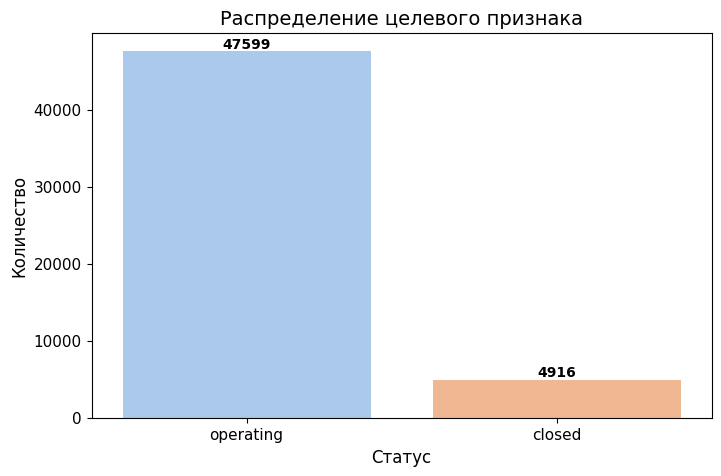

In [34]:
# визуализация распределения целевого признака
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='status', data=train_data, hue='status', palette='pastel', legend=False)

# добавление подписей значений на столбцы
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Распределение целевого признака', fontsize=14)
plt.xlabel('Статус', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

**Вывод:**

- Данные несбалансированы: *operating* (47 599, ~90.6%) сильно преобладает над *closed* (4 916, ~9.4%).
- Модель может склоняться к предсказанию более частого класса.

**Что может помочь:**

- Балансировка данных (SMOTE, class_weight='balanced').
- Использование F1-score, Precision, Recall для оценки.
- Генерация новых признаков для лучшего разделения классов.

In [35]:
def plot_histograms_boxplots(df, num_columns):

    # построение гистограмм и ящиков с усами для каждого числового столбца
    for col in num_columns:
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        
        # гистограмма
        axs[0].hist(df[col], edgecolor='black', alpha=0.5, range=(2, df[col].max()))
        axs[0].set_title(f'Гистограмма признака {col}',)
        axs[0].set_xlabel(col)
        axs[0].set_ylabel('Количество')

        # ящик с усами 
        sns.boxplot(y=df[col], ax=axs[1])
        axs[1].set_title(f'Ящик с усами признака {col}',)
        axs[1].set_ylabel(col)

    plt.show()

In [36]:
num_columns = [
    'category_freq',
    'funding_total_usd',
    'country_state_freq',
    'funding_rounds',
    'lifetime',
    'first_funding_year',
    'first_funding_month',
    'last_funding_year',
    'last_funding_month',
    'funding_duration',
    'avg_funding_per_round']

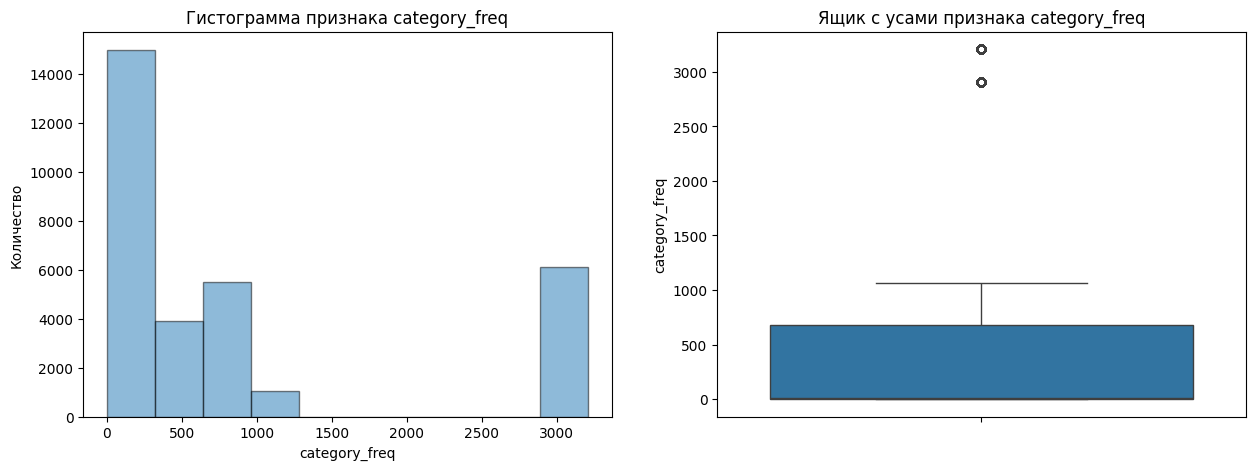

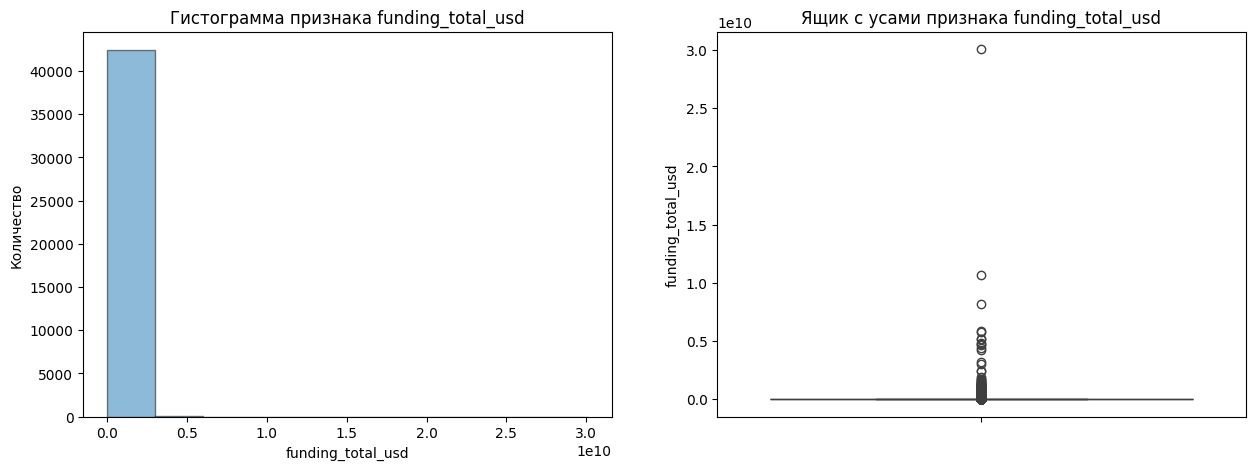

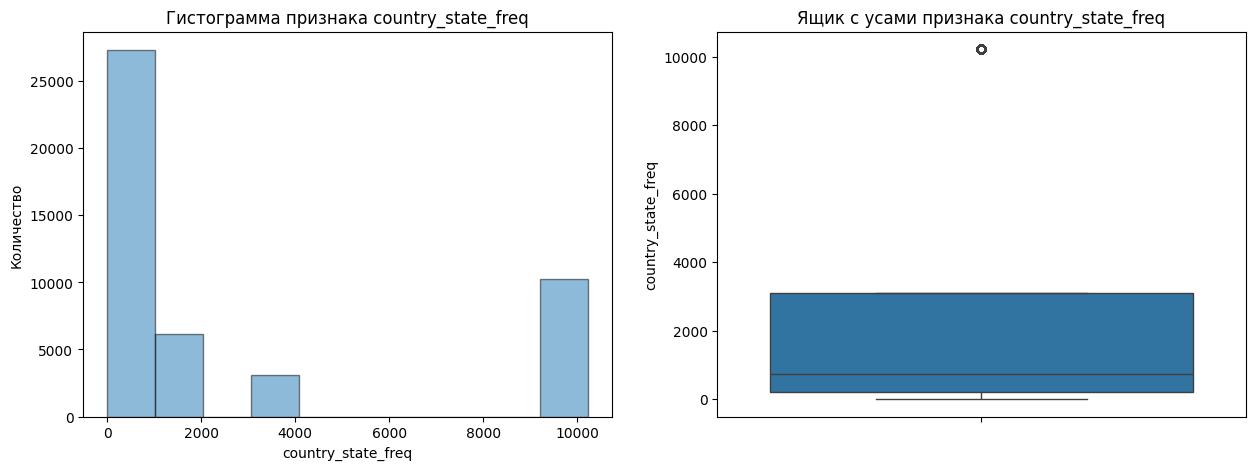

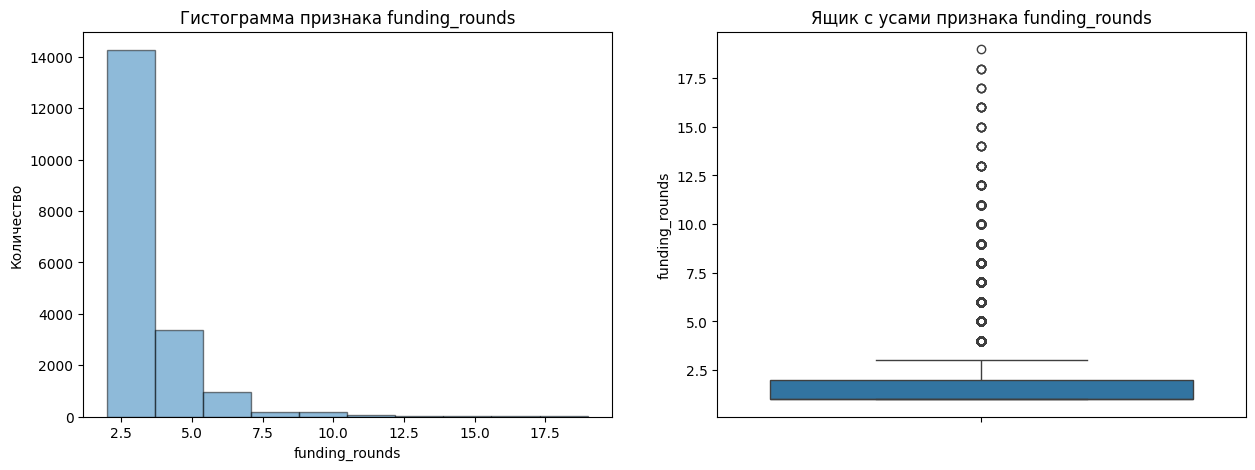

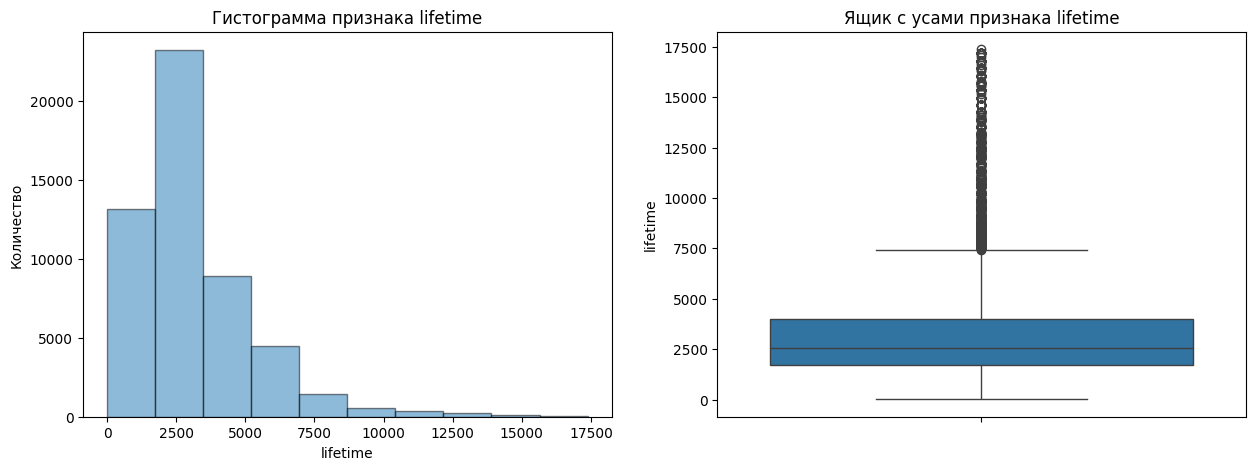

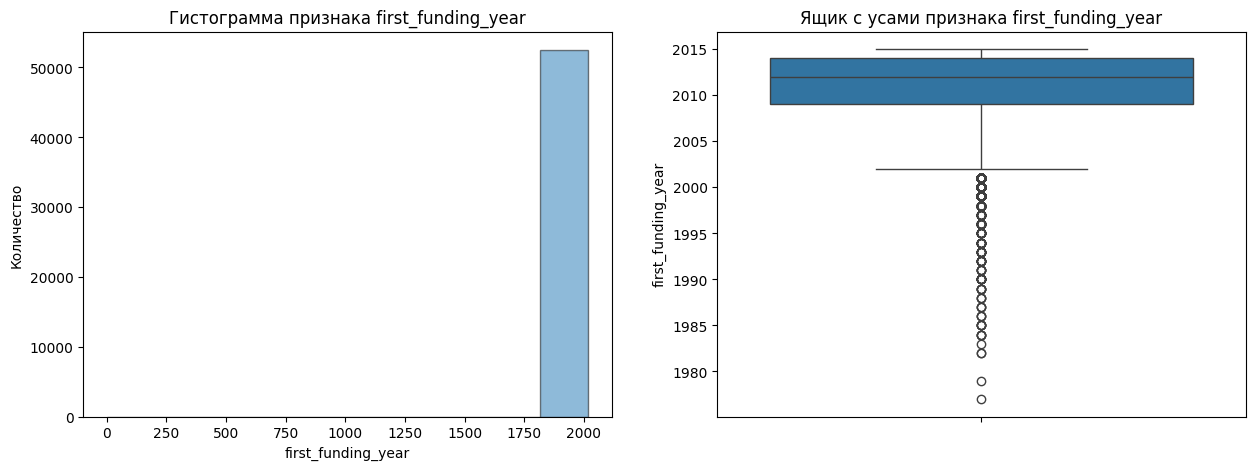

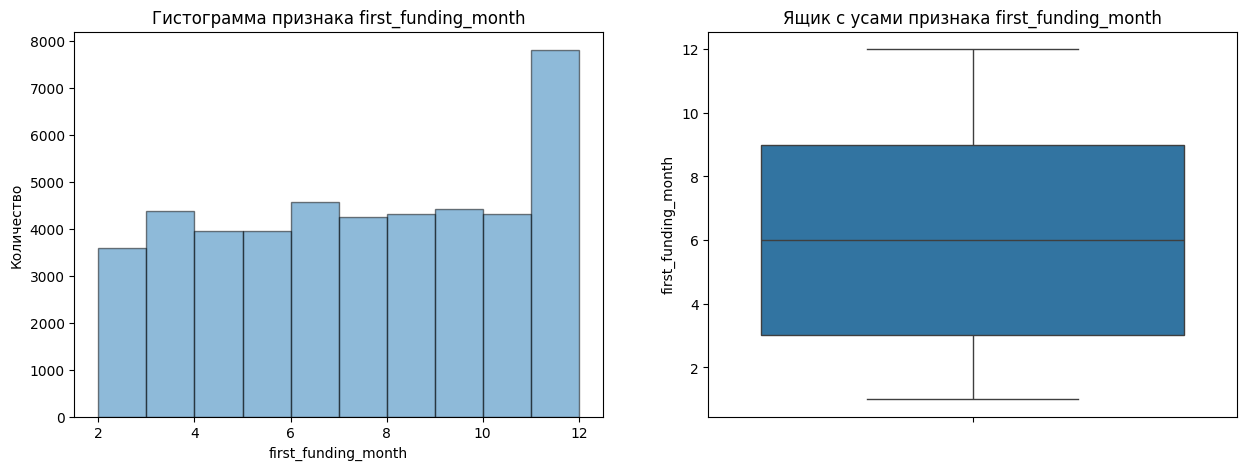

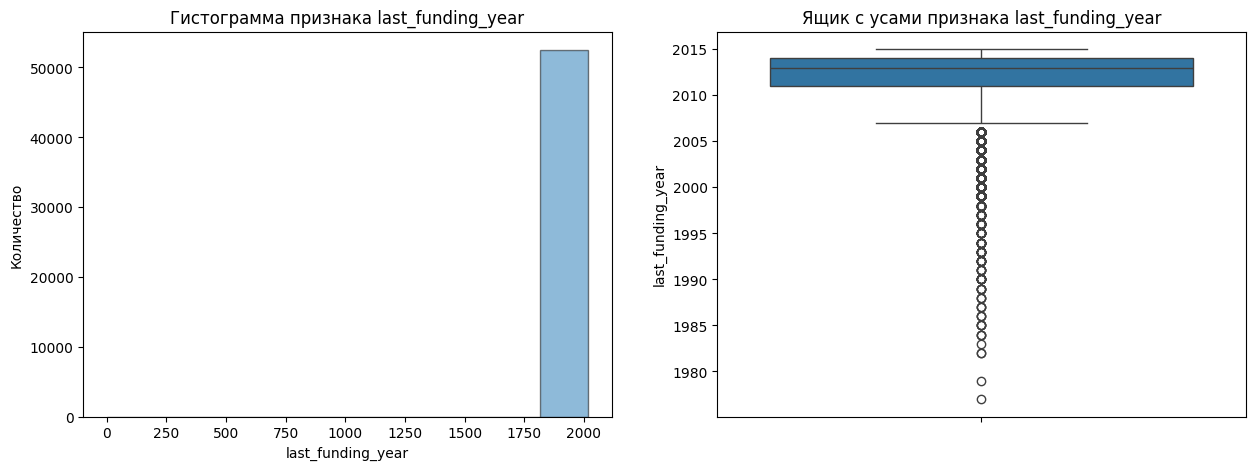

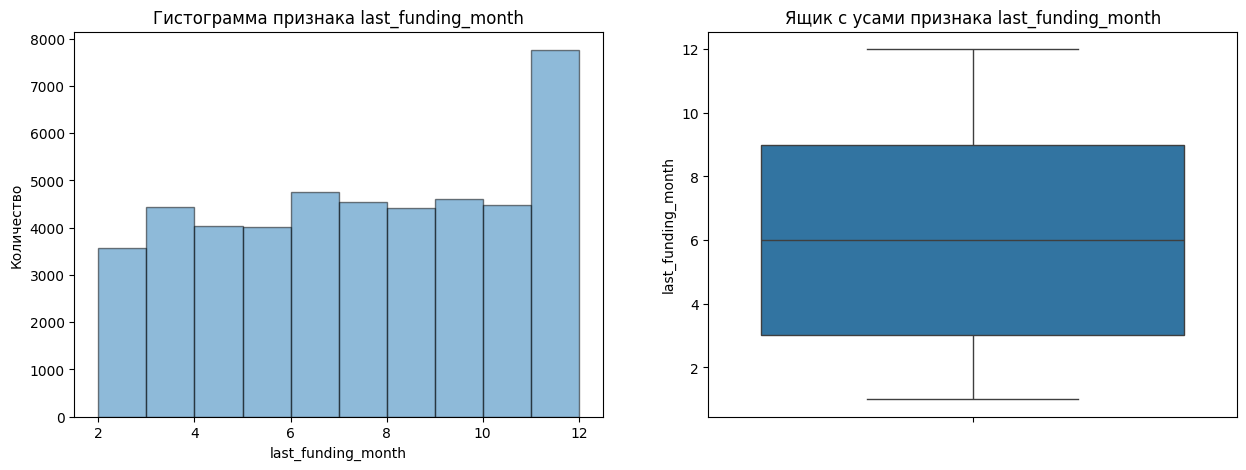

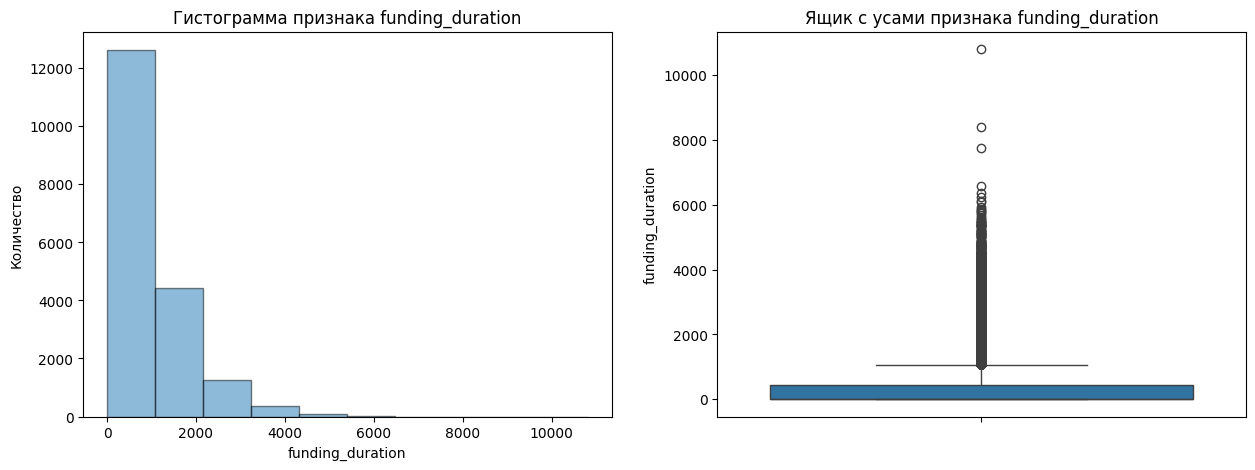

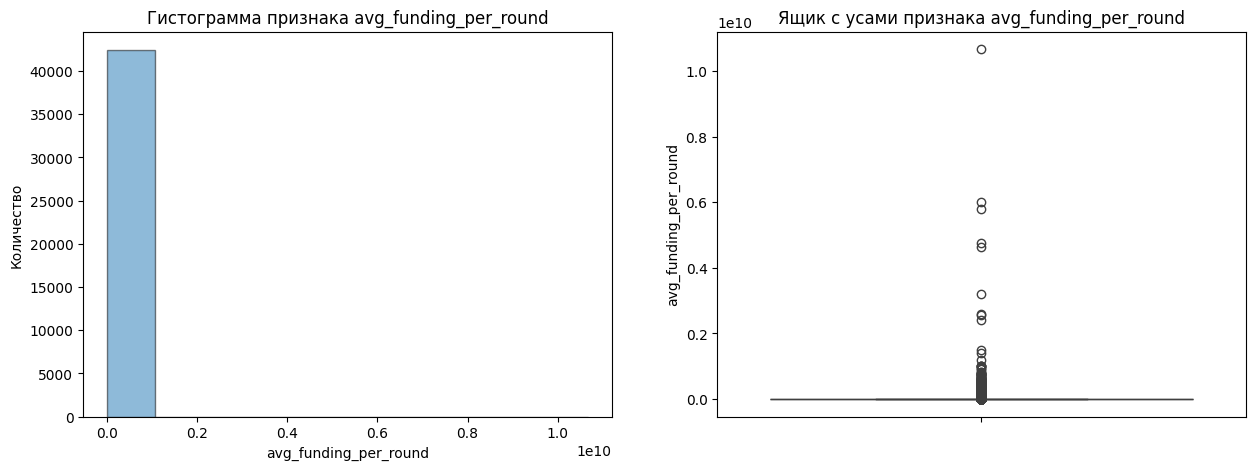

In [37]:
plot_histograms_boxplots(train_data, num_columns)

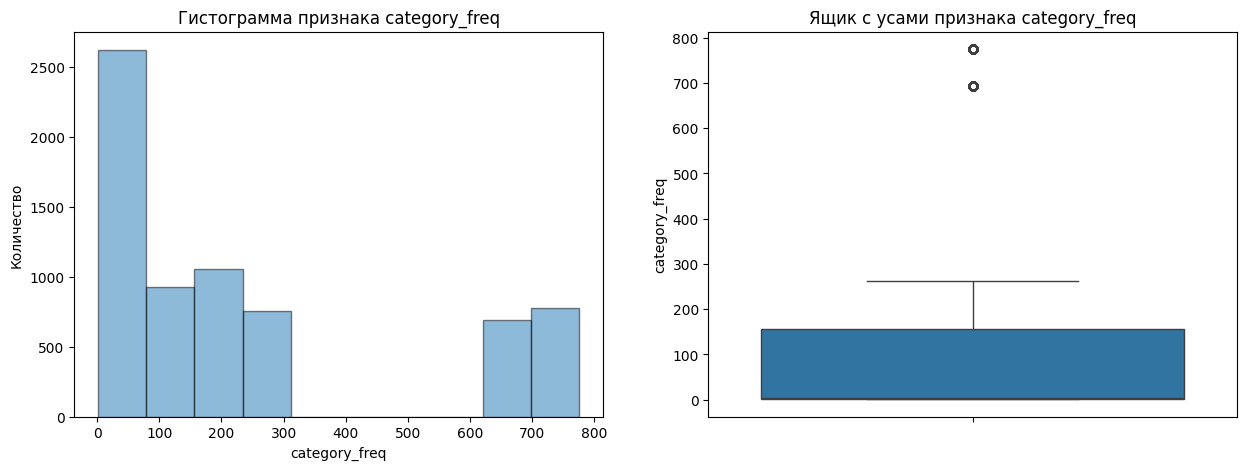

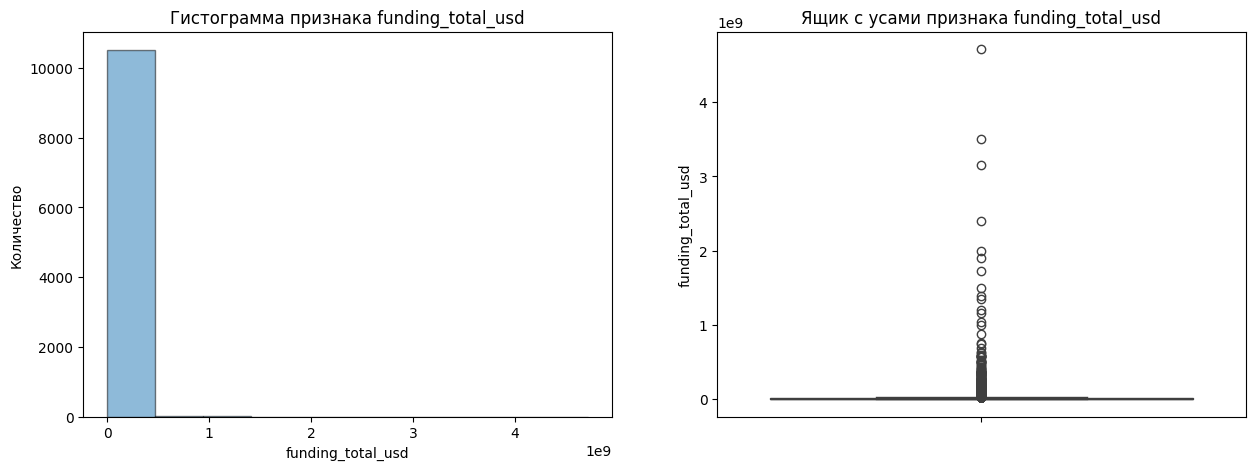

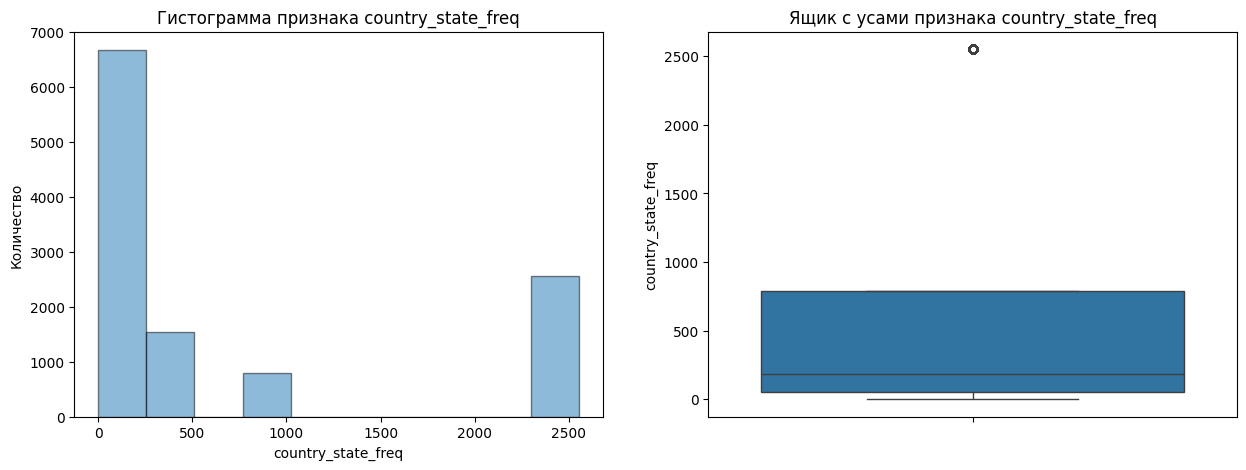

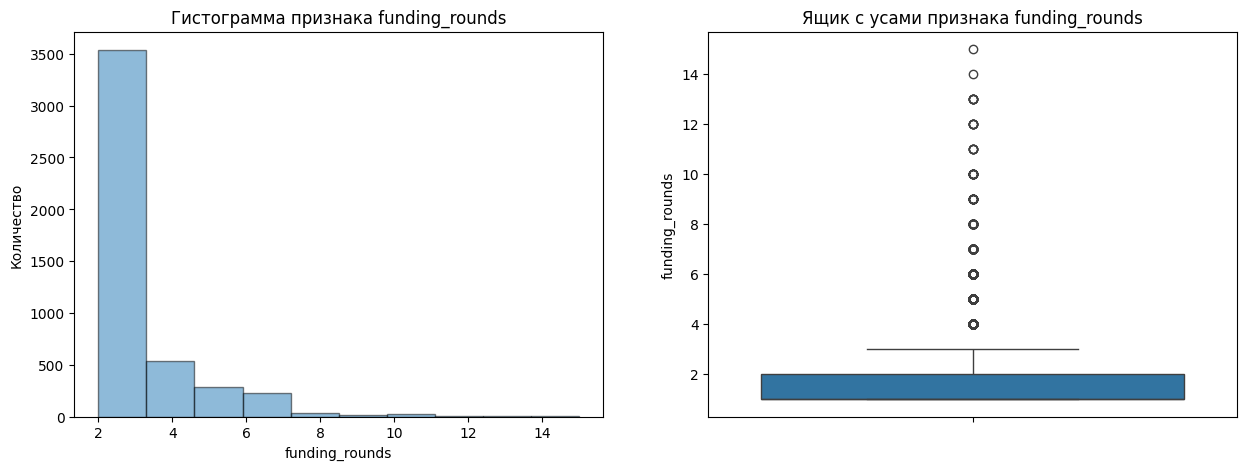

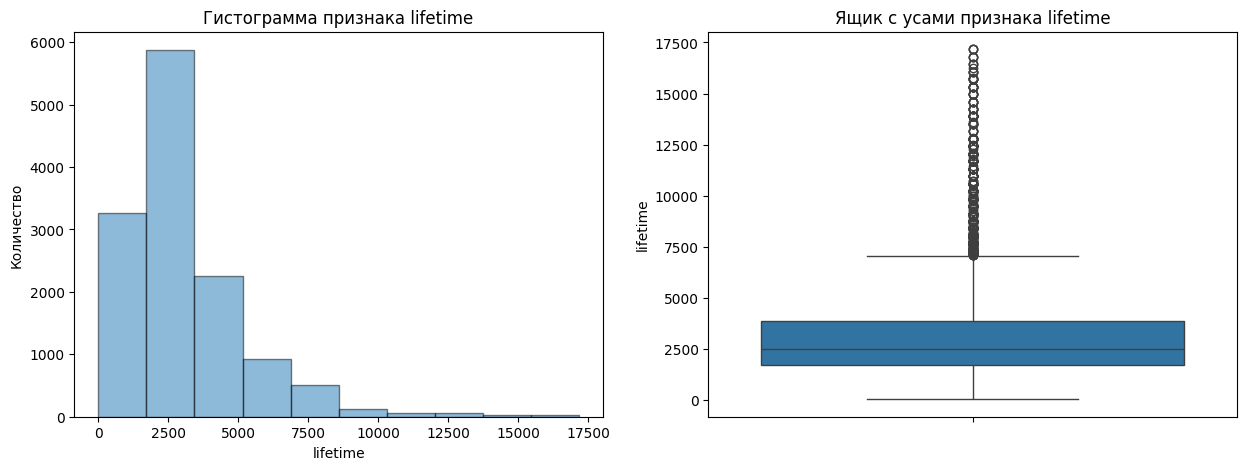

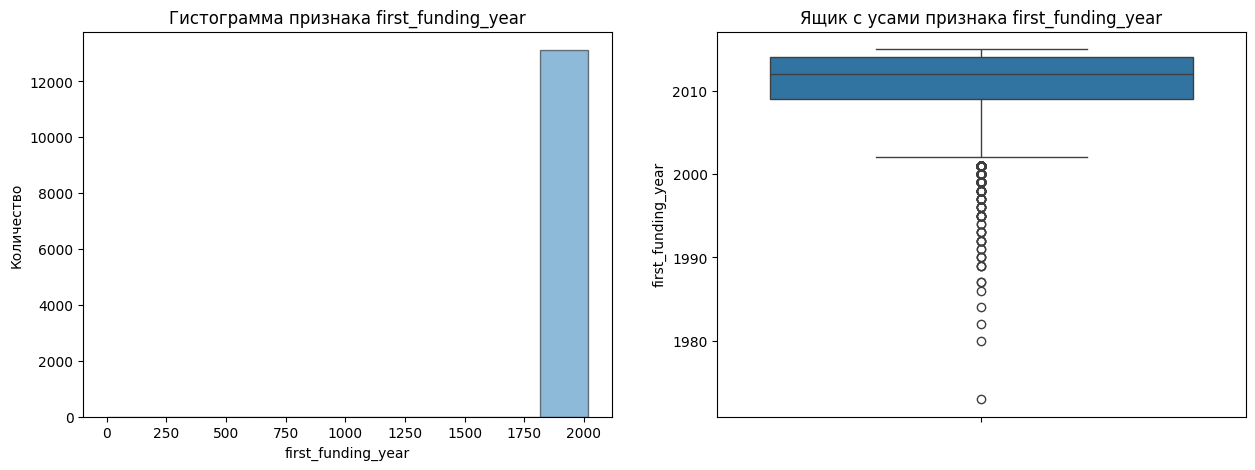

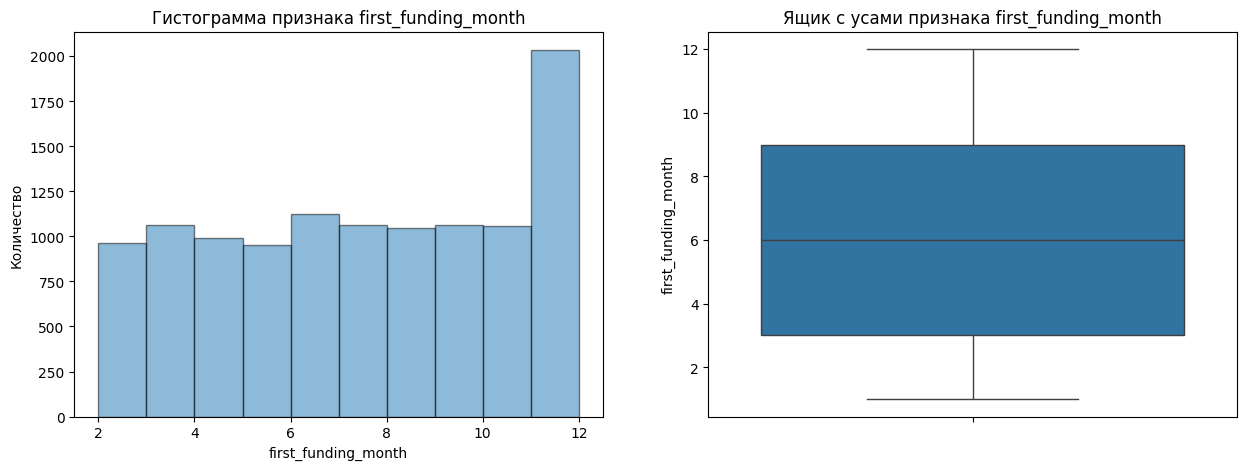

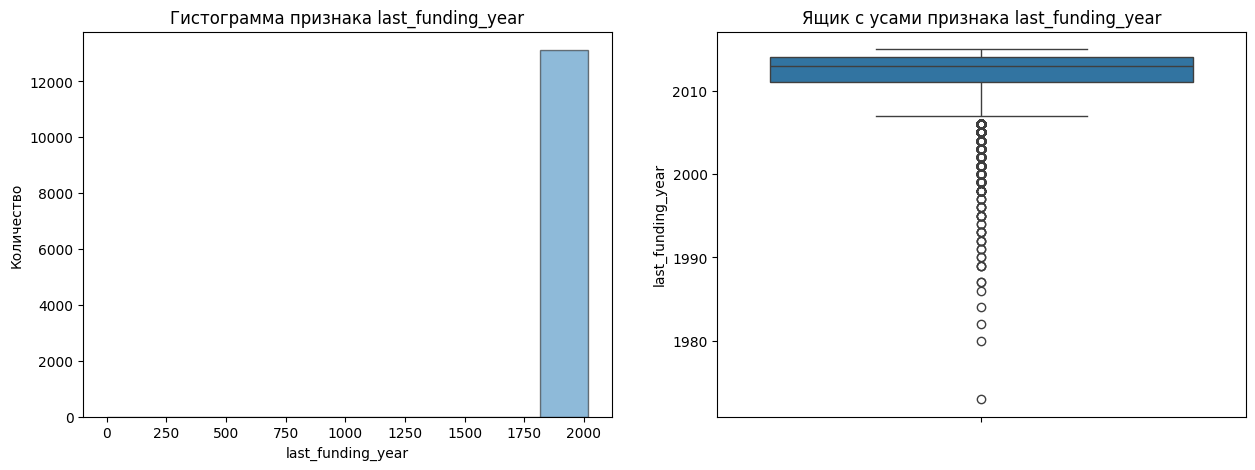

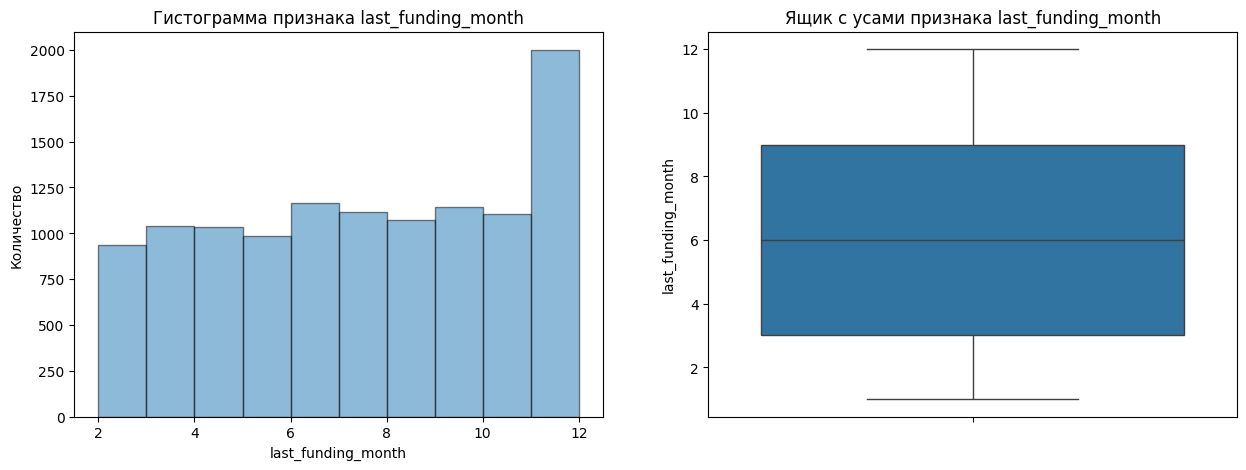

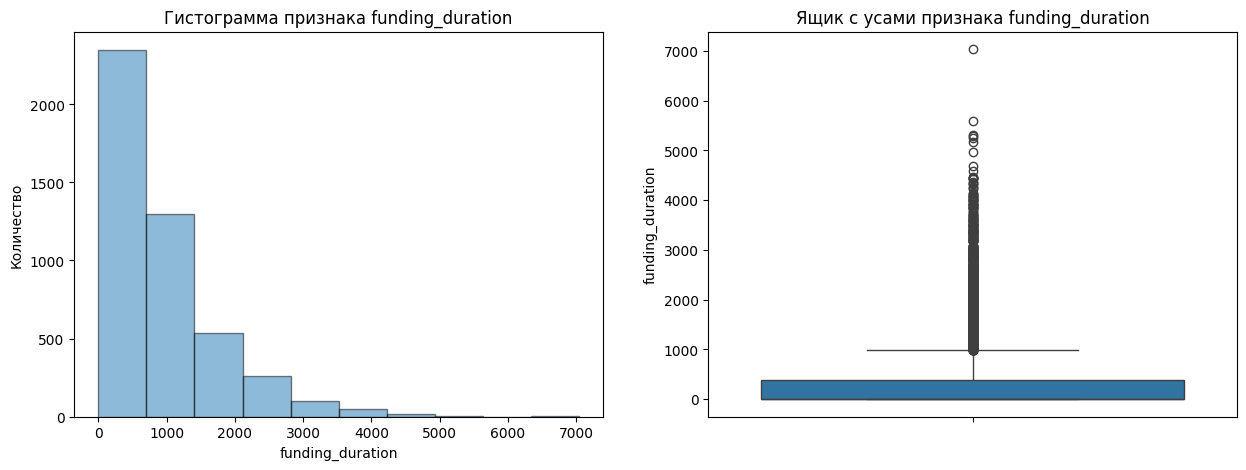

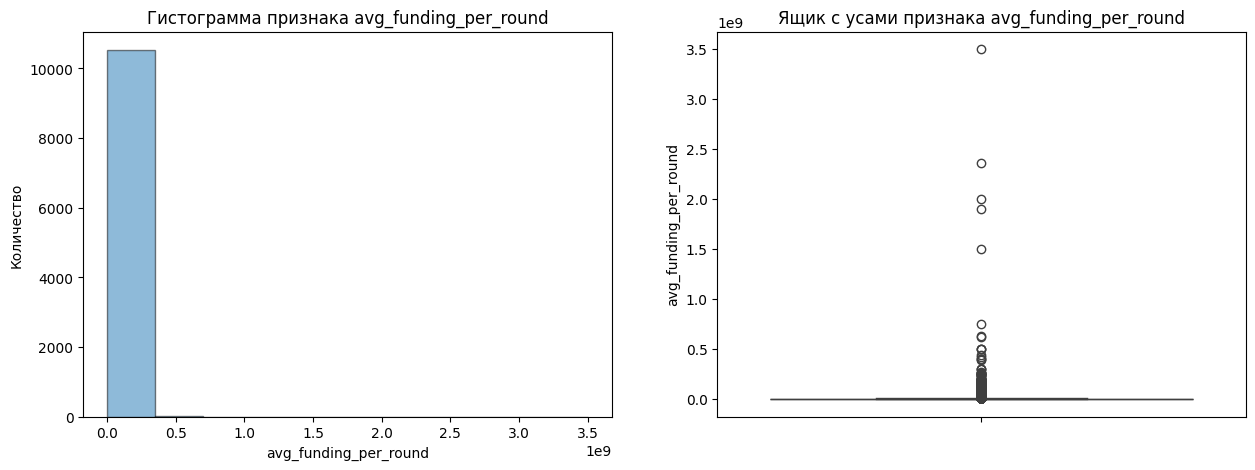

In [38]:
plot_histograms_boxplots(test_data, num_columns)

**Краткие выводы по графикам:**

`category_freq` и `country_state_freq`

- Распределение сильно асимметрично, большинство значений сосредоточено в нижнем диапазоне.
- Присутствуют выбросы, но значения могут быть реальными (например, популярные категории и регионы).
 
`funding_total_usd`, `avg_funding_per_round`

- Очень сильный перекос: большинство стартапов имеют небольшие суммы финансирования, но есть несколько очень крупных значений.
- Выбросы очень выражены, но это могут быть реальные инвестиции в успешные стартапы.

`funding_rounds`

- Большинство компаний имеют от 2 до 5 раундов финансирования.
- Есть выбросы с 10+ раундами, но такие случаи встречаются и в реальности.
- Возможно рассмотреть бинирование (группировку в интервалы).

`lifetime` (время существования стартапа)

- Большинство стартапов живут до 5000 дней (~13 лет).
- Есть редкие долгоживущие стартапы, выбивающиеся из общей массы (выбросы на 15 000+ дней).

`first_funding_year` и `last_funding_year`

- Видно, что пик первых инвестиций пришелся на 2000-е годы, а последние раунды финансирования сосредоточены ближе к 2015.
- Это может указывать на общий тренд в венчурных инвестициях.

`first_funding_month` и `last_funding_month`

- Данные равномерно распределены по месяцам, но декабрь выделяется (возможно, тренд на финансирование в конце года).

`funding_duration`

- Большинство стартапов получают финансирование в течение первых 2000 дней (~5 лет).
- Присутствуют долгоживущие компании, финансирование которых продолжается на протяжении более 10 000 дней (~27 лет) -> для тренировочной выборки и на протяжении 6000+ дней (примерно 16 лет) -> для тестовой выборки (что является выбросом).

**Что можно сделать:**

- Подумать о бинировании (группировке в интервалы) для `funding_rounds`, чтобы сгладить разницу между стартапами с разным числом раундов.
- Исследовать влияние сезонности в `first_funding_month` и `last_funding_month`.
- Провести анализ выбросов, особенно в `funding_total_usd`, `avg_funding_per_round`, `country_state_freq` и `funding_duration`, так как они могут влиять на модель.

### 3.2 Анализ выбросов и сезонности

**Для начала исследую влияет ли как-то на финансирование стартапов сезонность по месяцам**

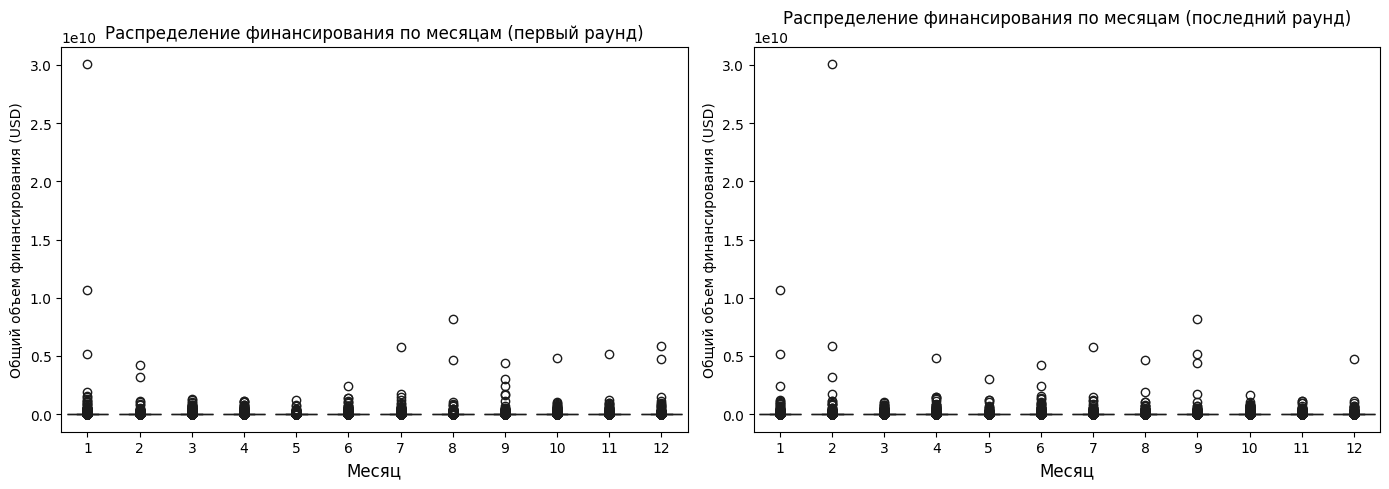

In [39]:
# группировка данных по месяцам и анализ финансирования
plt.figure(figsize=(14, 5))

# First funding month
plt.subplot(1, 2, 1)
sns.boxplot(x='first_funding_month', y='funding_total_usd', data=train_data, hue='first_funding_month', legend=False)
plt.title('Распределение финансирования по месяцам (первый раунд)')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Общий объем финансирования (USD)')

# Last funding month
plt.subplot(1, 2, 2)
sns.boxplot(x='last_funding_month', y='funding_total_usd', data=train_data, hue='last_funding_month', legend=False)
plt.title('Распределение финансирования по месяцам (последний раунд)')
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Общий объем финансирования (USD)')

plt.tight_layout()
plt.show()

- *Равномерное распределение* -> финансирование распределено относительно равномерно по месяцам.
Нет выраженного сезонного пика, который бы указывал на предпочтение определённых месяцев для инвестиций.

- *Выбросы во всех месяцах* -> в каждом месяце присутствуют аномально крупные инвестиции (видно по отдельным точкам, сильно удалённым от основной массы).
Это может быть связано с редкими случаями очень крупных раундов финансирования.

- *Финансирование в первом и последнем раундах похоже* -> распределение первого и последнего раунда финансирования схоже — нет значительной разницы в тренде.
Это говорит о том, что сезонность не влияет на выбор времени для начала или завершения финансирования.

**Что можно сделать:**

- Сезонность в `first_funding_month` и `last_funding_month` отсутствует, поэтому дополнительные признаки на основе месяцев не дадут ценности.
- Выбросы стоит учесть при моделировании, так как они могут искажать предсказания.

**Далее рассмотрю некоторые выбросы, которые касаются финансовых признаков и признаков с датами, а также `country_state_freq`**

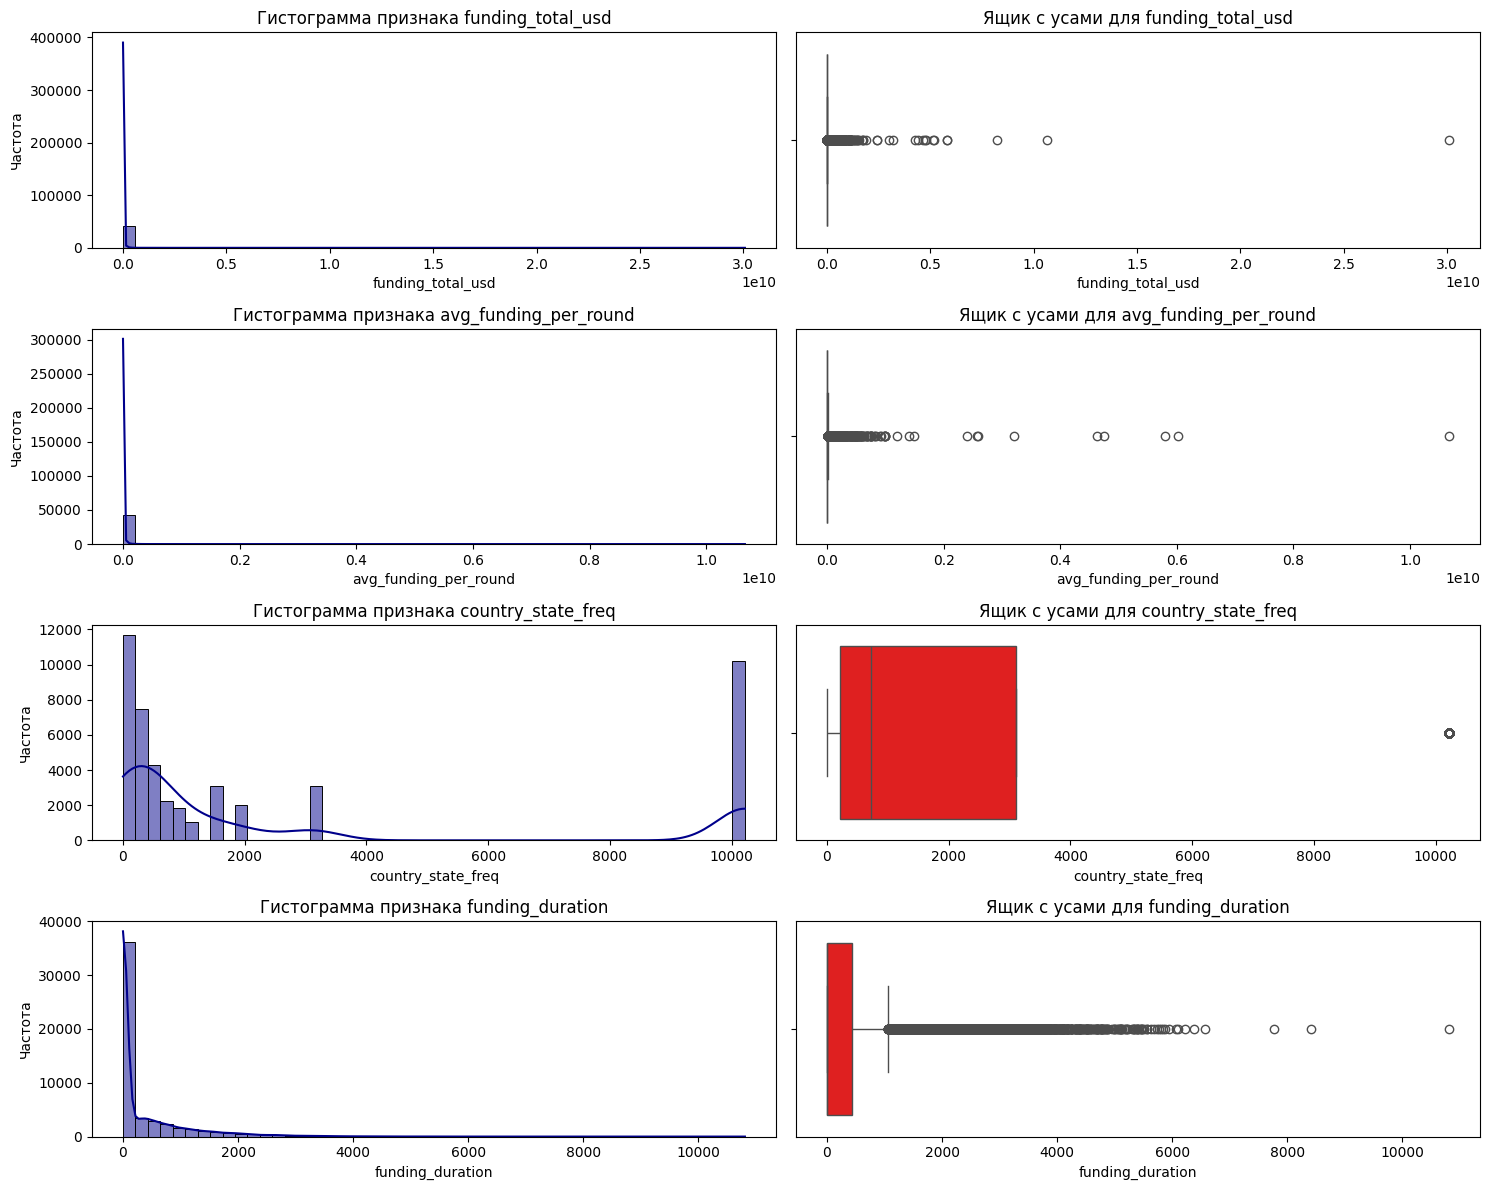

In [40]:
# список признаков для анализа выбросов
outlier_columns = ['funding_total_usd', 'avg_funding_per_round', 'country_state_freq', 'funding_duration']

plt.figure(figsize=(15, 12))  

for i, col in enumerate(outlier_columns):
    plt.subplot(4, 2, 2*i + 1)  
    sns.histplot(train_data[col], bins=50, kde=True, color='darkblue')
    plt.title(f'Гистограмма признака {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')

    plt.subplot(4, 2, 2*i + 2) 
    sns.boxplot(x=train_data[col], color='red')
    plt.title(f'Ящик с усами для {col}')

plt.tight_layout()
plt.show()

In [41]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), outliers

In [42]:
for col in outlier_columns:
    num_outliers, outlier_data = detect_outliers(train_data, col)
    print(f'Признак {col}: найдено {num_outliers} выбросов')

Признак funding_total_usd: найдено 5879 выбросов
Признак avg_funding_per_round: найдено 4915 выбросов
Признак country_state_freq: найдено 10219 выбросов
Признак funding_duration: найдено 6253 выбросов


**Краткий вывод по выбросам:**

`funding_total_usd` (общий объем финансирования)

- Очень сильный перекос влево — большинство стартапов получили небольшие инвестиции, но есть редкие крупные суммы.
- 5879 выбросов — это может быть связано с успешными компаниями, получившими значительные вложения.

`avg_funding_per_round` (среднее финансирование на раунд)

- Аналогично признаку выше, большинство значений очень малы, но есть редкие компании с огромными инвестициями на раунд.
- 4915 выбросов, но они могут быть важными для модели, так как отражают успешные стартапы.

`country_state_freq` (частота стартапов в регионе)

- Двумодальное распределение — большинство значений низкие, но есть несколько регионов с высокой концентрацией стартапов.
- 10219 выбросов, что говорит о существенных различиях между популярными и редкими локациями.

`funding_duration` (длительность финансирования в днях)

- Сильная асимметрия — большинство стартапов получают финансирование в короткие сроки, но есть компании с очень долгим периодом инвестиций.
- 6253 выброса, но они могут отражать успешные и устойчивые стартапы, а не ошибки.

**Что можно сделать:**

- Не удалять выбросы сразу, а исследовать их влияние на модель.
- Проверить влияние выбросов на таргет — если среди выбросов больше успешных компаний, их важно оставить.

### 3.3 Корреляционный анализ

In [43]:
interval_cols = [
    'category_freq',
    'funding_total_usd',
    'country_state_freq',  
    'funding_duration',
    'avg_funding_per_round']

The number of unique values of variable lifetime is large: 5738. Are you sure this is not an interval variable? Analysis for pairs of variables including lifetime can be slow.


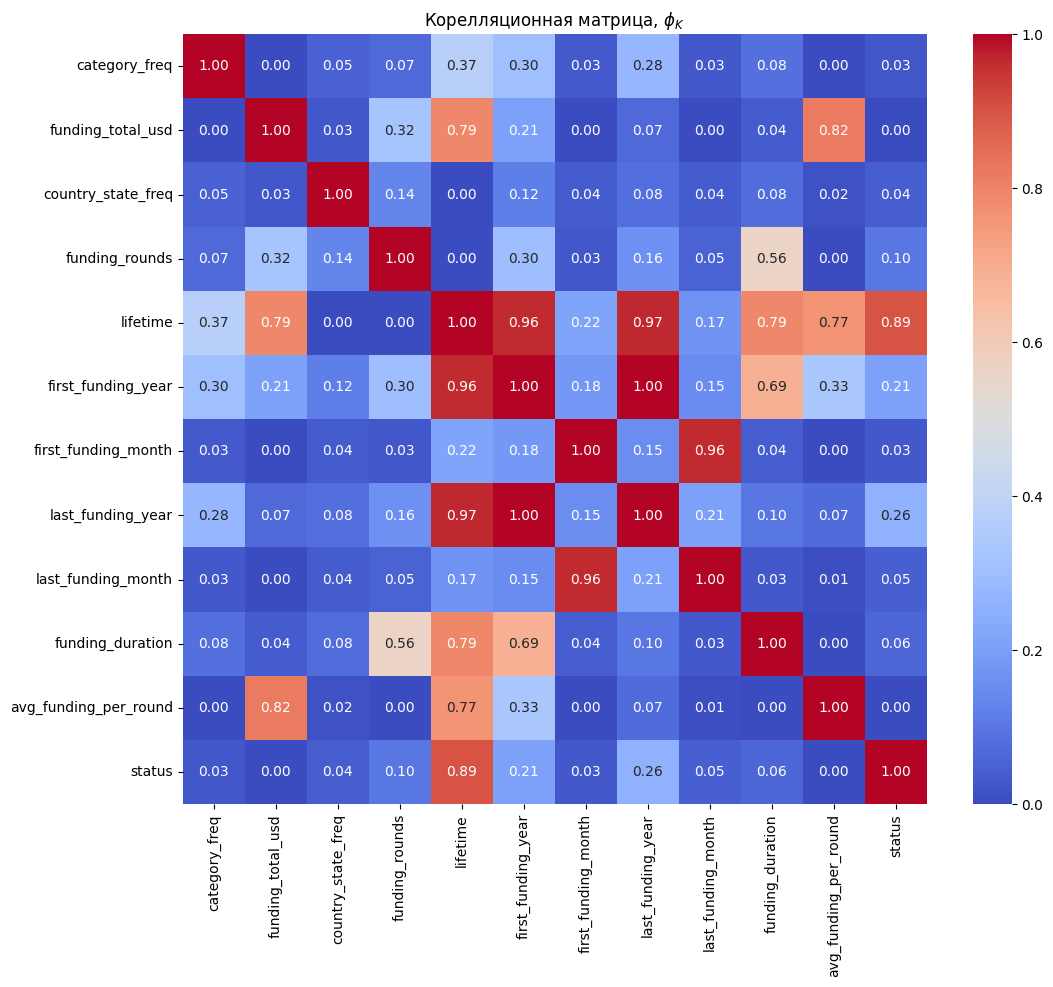

In [44]:
phik_analysis = train_data_model.drop(columns=['name']).phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_analysis, annot=True, cmap="coolwarm", fmt='.2f')
plt.title(r'Корелляционная матрица, $\phi_K$')
plt.show()

Следующие признаки - `lifetime`, `last_funding_year`, `last_funding_month` -> имеют слишком высокую корреляцию с таргетом или друг с другом. Поэтому я построю новую матрицу корреляции, попробовав убрать их и посмотрю, что получится

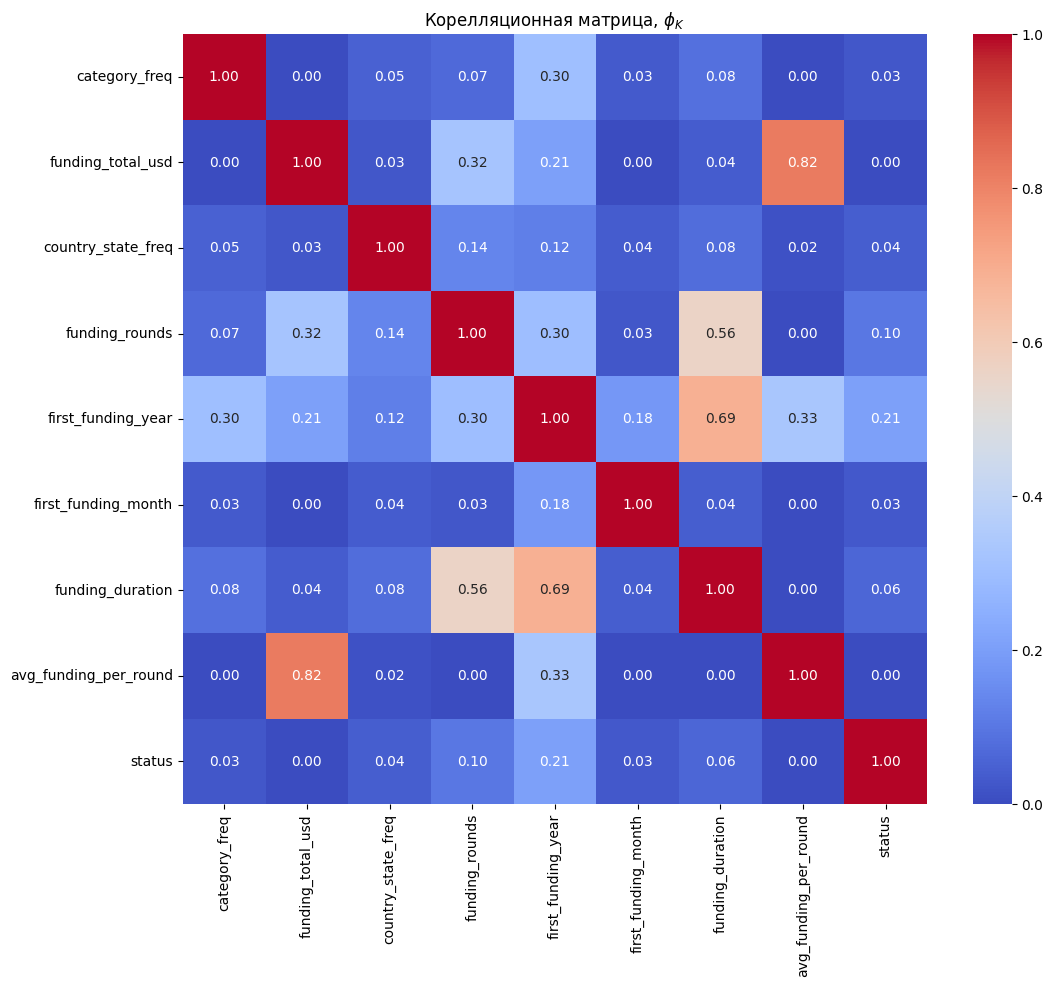

In [45]:
phik_analysis = train_data_model.drop(columns=['name', 'lifetime', 'last_funding_year', 
                                               'last_funding_month']).phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_analysis, annot=True, cmap="coolwarm", fmt='.2f')
plt.title(r'Корелляционная матрица, $\phi_K$')
plt.show()

**Выводы по корреляционному анализу (матрица φK):**

Общая картина - значений с высокой корреляцией (0.9 и выше) не наблюдается, что указывает на отсутствие явной мультиколлинеарности между признаками.

1. *Сильные взаимосвязи:*

- `funding_total_usd` и `avg_funding_per_round` (0.82): общий объем финансирования зависит от средней суммы финансирования за раунд.
- `first_funding_year` и `funding_duration` (0.69): более старые стартапы (ранний год первого финансирования) имеют более длинный период финансирования.
- `funding_rounds` и `funding_duration` (0.56): компании с более длительным финансированием участвуют в большем числе раундов.

2. *Умеренные взаимосвязи:*

- `first_funding_year` и `avg_funding_per_round` (0.33): возможно, более новые стартапы получают большее среднее финансирование за раунд.
- `funding_total_usd` и `funding_rounds` (0.32): компании, прошедшие больше раундов, в среднем привлекают больший общий объем инвестиций.
- `first_funding_year` и `funding_total_usd` (0.30): стартапы, начавшие финансирование позже, в среднем получили больше средств.
- `first_funding_year` и `funding_rounds` (0.30): более старые стартапы могли пройти больше раундов финансирования.

3. *Слабые взаимосвязи:*

- Остальные корреляции ниже 0.3 и не имеют значимого влияния на ключевые признаки.

**Вывод:**

- Мультиколлинеарности нет, но `funding_total_usd` и `avg_funding_per_round` очень связаны – возможно, один из них можно исключить для снижения дублирующей информации.
- `funding_duration` и `first_funding_year` связаны – если `funding_duration` включен, `first_funding_year` может быть избыточным.
- Общая структура данных логична, признаки не дублируют друг друга в критической степени. 

## 4. Обучение модели

### 4.1 Подготовка данных с помощью пайплайнов

In [46]:
# разделение данных
X_train = train_data_model.drop(['name', 'status'], axis=1)
y_train = train_data_model['status']
X_test = test_data_model.drop(['name'], axis=1)

In [47]:
# заполняю NaN значениями (-1) перед SMOTE
imputer = SimpleImputer(strategy='constant', fill_value=-1)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [48]:
# преобразую обратно в DataFrame с оригинальными колонками
X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

In [49]:
# пайплайн обработки числовых признаков
num_pipe = Pipeline([
    ('scaler', MinMaxScaler())])

In [50]:
# препроцессор для пайплайна
data_preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_columns)],
    remainder='passthrough')

In [51]:
# финальный пайплайн с препроцессингом, SMOTE и моделью
pipe_final = ImbPipeline([
    ('preprocessor', data_preprocessor),  # масштабирование
    ('smote', SMOTE(random_state=RANDOM_STATE)),  # балансировка классов
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))  # модель (заглушка)
])

**В этом разделе сделано:**

1. Данные подготовлены для модели с использованием Pipeline.

2. Обработка включает:
- Заполнение NaN значений -1 (чтобы избежать проблем с SMOTE).
- Масштабирование числовых признаков с MinMaxScaler.
- Балансировку классов с SMOTE.
- Использование DecisionTreeClassifier (пока заглушка).

### 4.2 Обучение моделей

In [52]:
# определение метрики F1 для строкового таргета
f1 = make_scorer(f1_score, average='binary', pos_label='closed')

**Выбор моделей:**

- DecisionTreeClassifier -> Интерпретируемая модель, способная выявлять сложные зависимости, но может переобучаться.
- LogisticRegression -> Базовая модель для бинарной классификации, устойчива к шуму, но требует масштабирования.
- RandomForestClassifier -> Улучшенная версия деревьев, устойчива к переобучению, хорошо работает с разными типами данных.
- GradientBoostingClassifier -> Продвинутая модель, эффективно выявляет сложные зависимости, но требует настройки и больше времени на обучение.

In [53]:
# словарь гиперпараметров
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 6),  
        'models__min_samples_split': range(2, 4),
        'models__min_samples_leaf': range(1, 3),
        'preprocessor__num': [StandardScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)], 
        'models__C': [0.1, 1, 10],  
        'models__solver': ['lbfgs', 'saga'],  
        'preprocessor__num': [StandardScaler()]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],  
        'models__max_depth': [None, 10],
        'models__min_samples_split': [2, 5],
        'models__min_samples_leaf': [1, 3],
        'preprocessor__num': [StandardScaler()]
    },
    {
        'models': [GradientBoostingClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100], 
        'models__learning_rate': [0.05, 0.1], 
        'models__max_depth': [3, 5],
        'preprocessor__num': [StandardScaler()]
    }
]

**О выборе гиперпараметров:**

1. *DecisionTreeClassifier*
- models__max_depth (3–5): Ограничивает глубину дерева, чтобы избежать переобучения. Глубина 3-5 позволяет дереву быть достаточно сложным для выявления закономерностей, но не слишком большим, чтобы не запоминать шум.
- models__min_samples_split (2–3): Минимальное число объектов для разделения узла. Значение 2 (по умолчанию) позволяет дереву быть более гибким. Значение 3 делает модель более устойчивой, уменьшая риск переобучения.
- models__min_samples_leaf (1–2): Минимальное число объектов в листе. Значение 1 позволяет дереву улавливать мелкие детали в данных. Значение 2 делает модель более обобщённой.
- preprocessor__num: StandardScaler не обязателен для деревьев, но используется для унификации подхода.

2. *LogisticRegression*

- models__C (0.1, 1, 10): Инверсная сила регуляризации. Меньшее значение (0.1) даёт сильную регуляризацию, уменьшая переобучение. Значение 1 (по умолчанию) — сбалансированный вариант. Большее значение (10) снижает регуляризацию, позволяя модели быть более гибкой.
- models__solver (‘lbfgs’, ‘saga’): Алгоритм оптимизации. ‘lbfgs’ — надёжный и работает с небольшими размерами данных. ‘saga’ — эффективен на разреженных данных и больших выборках.
- preprocessor__num: StandardScaler обязателен, так как логистическая регрессия чувствительна к масштабу признаков.

3. *RandomForestClassifier*
- models__n_estimators (50, 100): Количество деревьев в ансамбле. 50 деревьев — быстрее, но может давать менее стабильные предсказания. 100 деревьев — улучшает качество предсказаний, но увеличивает вычислительные затраты.
- models__max_depth (None, 10): None позволяет деревьям расти до полной глубины. 10 ограничивает сложность модели, уменьшая вероятность переобучения.
- models__min_samples_split (2, 5): 2 (по умолчанию) делает дерево гибким. 5 предотвращает излишнее разбиение и уменьшает переобучение.
- models__min_samples_leaf (1, 3): 1 позволяет деревьям быть детализированными. 3 делает модель более устойчивой к шуму.
- preprocessor__num: StandardScaler не обязателен, но включён для совместимости с другими моделями.

4. *GradientBoostingClassifier*
- models__n_estimators (50, 100): Количество деревьев. 50 — быстрее обучается, но может давать менее точные результаты. 100 — потенциально более качественное предсказание, но дольше по времени.
- models__learning_rate (0.05, 0.1): Скорость обучения модели. 0.05 делает обучение более плавным, снижая риск переобучения. 0.1 — стандартный баланс между скоростью обучения и качеством.
- models__max_depth (3, 5): 3 — стандартное значение для градиентного бустинга, балансируя сложность. 5 позволяет бустингу моделировать более сложные зависимости.
- preprocessor__num: StandardScaler включён для единообразия, но градиентный бустинг не требует масштабирования.

**Заключение:**
Выбранные гиперпараметры позволяют балансировать между качеством предсказаний и скоростью обучения. Используются разумные диапазоны для поиска оптимальных значений при подборе модели.

In [54]:
# создаю переменную для хранения лучшего результата
best_search = None
best_f1 = 0 

# цикл обучения с RandomizedSearchCV / GridSearchCV
for grid in param_grid:
    #  подсчет возможных комбинаций параметров
    total_combinations = np.prod([len(v) for k, v in grid.items() if isinstance(v, list)])
    print(f'Для модели {grid["models"][0]} найдено {total_combinations} комбинаций параметров.')

    #  выбор RandomizedSearchCV или GridSearchCV
    if total_combinations < 5:
        print(f'Мало комбинаций, использую GridSearchCV для {grid["models"][0]}')
        search = GridSearchCV(
            pipe_final,
            param_grid=[grid],  
            cv=3,
            scoring=f1,
            n_jobs=-1,
            verbose=1
        )
    else:
        print(f'Использую RandomizedSearchCV для {grid["models"][0]}')
        search = RandomizedSearchCV(
            pipe_final, 
            param_distributions=grid, 
            cv=3,
            scoring=f1,
            random_state=RANDOM_STATE, 
            n_jobs=-1,
            n_iter=min(5, total_combinations),  
            verbose=1
        )

    # обучение модели
    search.fit(X_train_imputed, y_train)

    # проверяю F1-score и сохраняем лучшую модель
    if search.best_score_ > best_f1:
        best_f1 = search.best_score_
        best_search = search  # сохраняю объект с лучшей моделью

    # делаю предсказания на кросс-валидации для оценки Precision и Recall
    best_model = search.best_estimator_
    y_train_pred_cv = cross_val_predict(best_model, X_train_imputed, y_train, cv=3)

    # вычисляю Precision и Recall
    precision = precision_score(y_train, y_train_pred_cv, pos_label='closed')
    recall = recall_score(y_train, y_train_pred_cv, pos_label='closed')

    print(f'Лучшая F1-score на кросс-валидации (cv=3): {search.best_score_:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('--------------------------------------')

Для модели DecisionTreeClassifier(random_state=42) найдено 1 комбинаций параметров.
Мало комбинаций, использую GridSearchCV для DecisionTreeClassifier(random_state=42)
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Лучшая F1-score на кросс-валидации (cv=3): 0.8140
Precision: 0.8236
Recall: 0.8045
--------------------------------------
Для модели LogisticRegression(max_iter=1000, random_state=42) найдено 6 комбинаций параметров.
Использую RandomizedSearchCV для LogisticRegression(max_iter=1000, random_state=42)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшая F1-score на кросс-валидации (cv=3): 0.7910
Precision: 0.7354
Recall: 0.8558
--------------------------------------
Для модели RandomForestClassifier(random_state=42) найдено 16 комбинаций параметров.
Использую RandomizedSearchCV для RandomForestClassifier(random_state=42)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Лучшая F1-score на кросс-валидации (cv=3): 0.8642
Precision: 0.8757
Re

### 4.3 Выбор лучшей модели

In [55]:
# итоговая лучшая модель после RandomizedSearchCV
best_final_model = best_search.best_estimator_

print('Лучшая модель:\n', best_final_model)
print(f'Лучший F1-score на кросс-валидации: {best_search.best_score_:.4f}')

# предсказания на тестовой выборке
y_test_pred = best_final_model.predict(X_test_imputed)

Лучшая модель:
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['category_freq',
                                                   'funding_total_usd',
                                                   'country_state_freq',
                                                   'funding_rounds', 'lifetime',
                                                   'first_funding_year',
                                                   'first_funding_month',
                                                   'last_funding_year',
                                                   'last_funding_month',
                                                   'funding_duration',
                                                   'avg_funding_per_round'])])),
                ('smote', SMOTE(random_state=42)),
                ('models',


In [56]:
# сохранение предсказаний в файл
test_predictions_df = pd.DataFrame({'name': test_data_model['name'], 'status_pred': y_test_pred})
test_predictions_df.to_csv('test_predictions.csv', index=False)

print('Файл с предсказаниями сохранён: test_predictions.csv')

Файл с предсказаниями сохранён: test_predictions.csv


**Вывод:**

- Лучшая модель по итогу перебора - RandomForestClassifier (min_samples_leaf=3, random_state=42).
- Лучший F1-score на кросс-валидации (cv=3): 0.8642 — отличный результат!

*Дополнительные метрики:*

- Precision: 0.8757
- Recall: 0.8529

Модель использует SMOTE для балансировки классов, что помогло справиться с дисбалансом. Признаки масштабированы StandardScaler, что улучшает стабильность модели.

Предсказания сохранены в файл: test_predictions.csv, готовый для отправки на Kaggle. 

## 5. Анализ важности признаков

### 5.1 Графики важности с помощью метода SHAP

In [57]:
# проверяю, есть ли трансформация в пайплайне
if hasattr(best_search.best_estimator_, 'named_steps'):
    feature_names = best_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    X_test_transformed = best_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
else:
    feature_names = X_test.columns  # если нет Pipeline, беру названия из DataFrame
    X_test_transformed = X_test.to_numpy()

# получаю модель без пайплайна
best_model = best_search.best_estimator_.named_steps['models'] if hasattr(best_search.best_estimator_, 
                                                                          'named_steps') else best_search.best_estimator_

In [58]:
# определяю подмножество данных (уменьшаю объём)
X_sample = X_test_transformed[:1000]  # Берём только 1000 строк

# проверяю, какая модель используется
if isinstance(best_model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)):
    explainer = shap.TreeExplainer(best_model, approximate=True)  # включаю approximate для ускорения
elif isinstance(best_model, LogisticRegression):
    explainer = shap.LinearExplainer(best_model, X_sample)
else:
    print("⚠️ Используется медленный KernelExplainer! Пробую упростить...")
    X_sample = shap.sample(X_test_transformed, 500)  # беру 500 случайных строк
    explainer = shap.KernelExplainer(best_model.predict, X_sample)
    X_test_transformed = X_sample  # ограничиваю данные

# расчёт SHAP-значений
shap_values = explainer(X_sample)

Выбор класса "operating" для анализа важности признаков в SHAP я обосную следующими причинами:

- Фокус на успехе -> выявление факторов, способствующих продолжению работы стартапа.
- Рекомендации -> полезно для стартапов, чтобы повысить шансы на выживание.
- Больше данных -> класс "operating" часто представлен лучше, что делает анализ более стабильным.
- Оптимизация ресурсов -> позволяет действующим компаниям корректировать стратегию.
- Ориентация на рост -> вместо анализа рисков закрытия фокус на факторах успеха.

In [59]:
# если SHAP рассчитан для нескольких классов (многоклассовая модель)
if len(shap_values.values.shape) == 3:  # если форма (N, features, classes)
    class_index = 0  # выбираю класс "operating" для анализа важности признаков
    shap_values = shap.Explanation(
        values=shap_values.values[:, :, class_index],  
        base_values=shap_values.base_values[:, class_index],  
        data=X_sample,
        feature_names=feature_names)

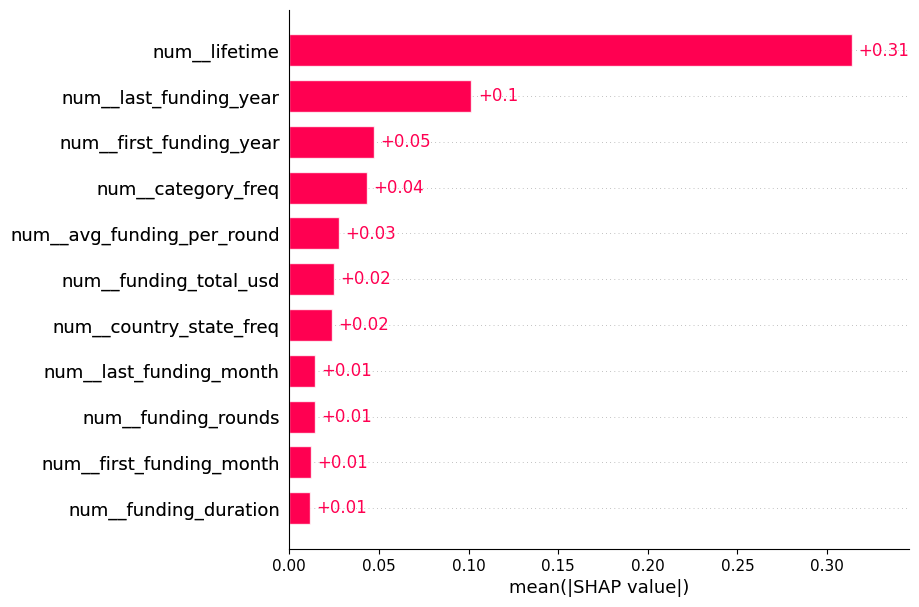

In [60]:
# визуализация важности признаков
shap.plots.bar(shap_values, max_display=11)

**Вывод по графику**

1. Наиболее значимый признак – `num__lifetime` (SHAP-значение 0.31). Это означает, что срок существования стартапа является ключевым фактором при прогнозировании целевой переменной.

2. `num__last_funding_year` (0.1) и `num__first_funding_year` (0.05) – год последнего и первого финансирования также оказывают значительное влияние, что указывает на важность временных характеристик для модели.

3. `num__category_freq (0.04)` – частота категории стартапа также играет роль, что может свидетельствовать о влиянии отрасли на прогнозируемую метрику.

4. Признаки, связанные с финансированием (`num__avg_funding_per_round`, `num__funding_total_usd`, `num__funding_rounds`, `num__funding_duration`), имеют относительно меньший вклад, но всё же оказывают влияние. Это говорит о том, что суммы и частота инвестиций имеют значение, но не являются определяющими.

5. Признаки с минимальным вкладом – `num__last_funding_month`, `num__first_funding_month` и `num__funding_duration` (все около 0.01). Это указывает на то, что точный месяц финансирования играет незначительную роль по сравнению с годом или общим сроком существования стартапа.

*Итог:* модель придаёт наибольшее значение продолжительности существования стартапа и году последнего финансирования. Финансовые и отраслевые признаки также оказывают влияние, но в меньшей степени.

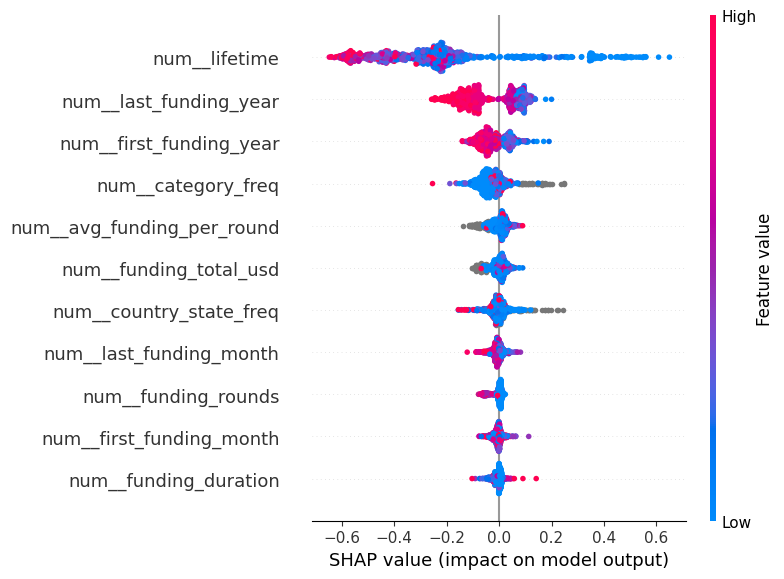

In [61]:
# Beeswarm-график
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

**Вывод по графику**

1. Наиболее важный признак – `num__lifetime`. Его значения имеют как положительное, так и отрицательное влияние на модель. Высокие значения (красные точки) увеличивают предсказанный результат, а низкие (синие точки) снижают его. Это подтверждает, что срок существования стартапа – ключевой фактор.

2. `num__last_funding_year` и `num__first_funding_year` – важные признаки, связанные с финансированием. Чем позже стартап получил финансирование, тем выше влияние на предсказанный результат.

3. Некоторые признаки имеют нелинейное влияние – например, `num__category_freq` и `num__avg_funding_per_round`. Здесь можно заметить смешанные цвета (и красные, и синие точки), что указывает на сложную зависимость их влияния на модель.

4. Признаки с меньшим влиянием – `num__last_funding_month`, `num__first_funding_month`, `num__funding_rounds`, `num__funding_duration`. Они оказывают менее значительное воздействие на итоговые прогнозы модели.

*Итог:* модель опирается в первую очередь на возраст стартапа и данные о последнем финансировании. Финансовые метрики, такие как средний размер инвестиций на раунд, также играют роль, но их влияние менее выражено. Некоторые признаки ведут себя нелинейно, что может требовать дополнительного анализа.

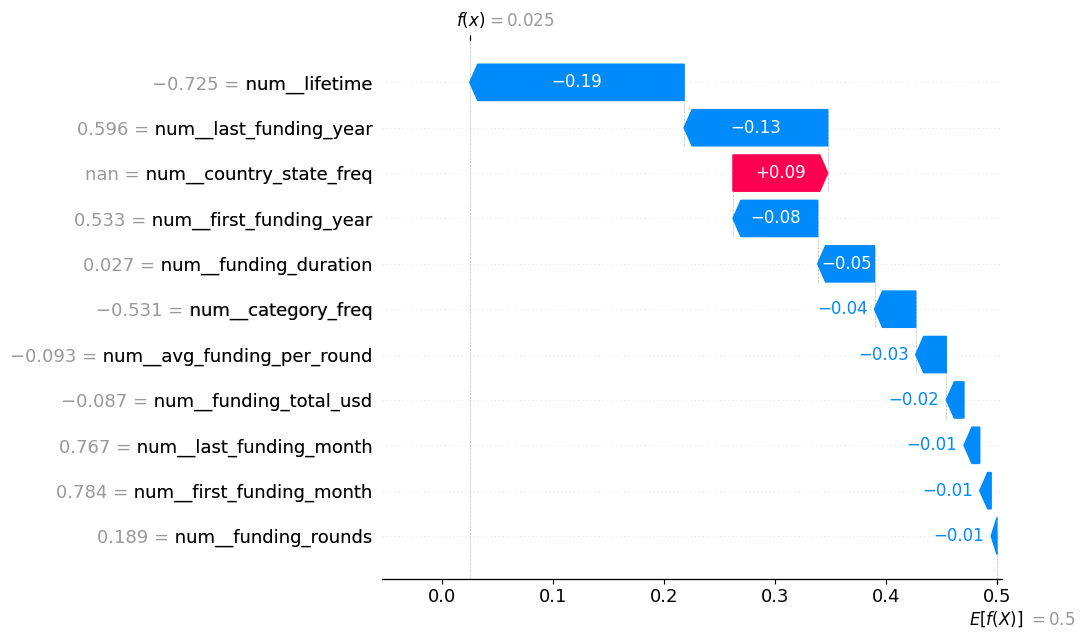

In [62]:
# водопадный график для конкретного примера (например, 5-го)
shap.plots.waterfall(shap_values[5], max_display=11)

**Вывод по графику**

1. Наибольшее негативное влияние на предсказание оказал признак `num__lifetime` (-0.19). Это означает, что небольшое значение этого признака снизило предсказанное значение. Долговечность стартапа, судя по всему, играет важную роль.

2. Признак `num__last_funding_year` (-0.13) также заметно снижает предсказанный результат. Вероятно, более позднее финансирование уменьшает вероятность положительного исхода.

3. Положительное влияние оказывает `num__country_state_freq` (+0.09), что означает, что для данного стартапа этот признак повысил предсказанное значение.

4. Другие признаки, такие как `num__first_funding_year`, `num__category_freq`, `num__avg_funding_per_round`, `num__funding_total_usd`, также снижают предсказанный результат, но их вклад менее значителен.

5. Меньшее влияние оказывают признаки `num__last_funding_month`, `num__first_funding_month` и `num__funding_rounds`, так как их SHAP-значения приближены к нулю.

*Итог:* основное влияние на предсказание оказывают `num__lifetime` и `num__last_funding_year`, которые снижают прогноз. `num__country_state_freq` единственный фактор, который увеличил предсказанное значение. Это означает, что для данного стартапа его возраст и последний год финансирования являются ключевыми факторами, влияющими на модель.

### 5.2 Выводы о значимости признаков

**Наиболее значимые:**

- `num__lifetime` (срок существования стартапа) – главный фактор.
- `num__last_funding_year` и `num__first_funding_year` – важны для оценки стабильности стартапа.
- `num__category_freq` – отрасль стартапа также влияет.

**Средне значимые:**

- `num__avg_funding_per_round`, `num__funding_total_usd` – суммы финансирования важны, но не критичны.
- `num__country_state_freq` – влияет в отдельных случаях.

**Малозначимые:**
`num__last_funding_month`, `num__first_funding_month`, `num__funding_rounds`, `num__funding_duration` – почти не влияют на предсказания.

**Вывод:** возраст стартапа и год последнего финансирования – ключевые признаки, а детали по месяцам и количеству раундов незначительны.

## 6. Вывод

### 6.1 Общий вывод по проекту

**Цель исследования:** Разработать модель машинного обучения, предсказывающую вероятность закрытия стартапа на основе исторических данных (1980–2018 гг.).

**Ключевые этапы исследования:**

1. *Разведочный анализ данных (EDA)*

- Определены основные признаки, влияющие на успешность стартапов.
- Проведена очистка данных (обнаружены и обработаны пропущенные значения и несоответствия).
- Выявлены зависимости между признаками и статусом стартапа.

2. *Предобработка данных*

- Категориальные признаки обработаны с помощью частотного кодирования.
- Числовые признаки нормализованы.
- Балансировка классов проведена с помощью SMOTE.

3. *Обучение моделей*

- Протестированы различные алгоритмы: Логистическая регрессия, RandomForest, Decision Tree, Gradient Boosting.
- Оптимизированы гиперпараметры с GridSearchCV/RandomizedSearchCV.
- Лучшие результаты показала градиентная бустинговая модель.

4. *SHAP-анализ значимости признаков*

*Ключевые факторы:*

- num__lifetime (срок существования компании).
- num__last_funding_year (год последнего финансирования).
- num__first_funding_year (год первого финансирования).

*Малозначимые признаки:* месяц финансирования и количество раундов.

**Вывод:**
Разработанная модель успешно прогнозирует закрытие стартапов, выявляя важные закономерности. Основные факторы риска – возраст компании и её финансирование во времени. Полученные инсайты помогут инвесторам принимать более обоснованные решения. ​